# ДЗ 1 По РИС ИНС

## Выполнил Леликов А.М. (9 вариант)

### Импортирование вспомогательных библиотек

In [30]:
import numpy as np
import matplotlib.pyplot as plt

### Функции

In [31]:
# Функция изменяющая вектор в кососиметрическую матрицу
def SkewSymmMatr(a : np.array) -> np.array:
    Ax= np.array(
        [[0.0,-a[2],a[1]],
        [a[2],0.0,-a[0]],
        [-a[1],a[0],0.0]])
    return Ax

In [32]:
# Векторное произведение
def cross(a : np.array ,b : np.array) -> np.array:
    axb = SkewSymmMatr(a) @ b
    return axb

In [33]:
# огроничение для курса
def twoPiBound(heading : float) -> float:
    if heading < 0:
        heading = heading + 2.0 * np.pi

    return heading

In [34]:
# МНК BODY-> Navigation (ENUp)
def DCM_bn(heading : float, pitch : float, roll : float) -> np.array:
    sz = np.sin(-heading)
    cz = np.cos(-heading)
    sy = np.sin(roll)
    cy = np.cos(roll)
    sx = np.sin(pitch)
    cx = np.cos(pitch)

    Cx = np.array([[1, 0, 0],[0, cx, sx],[0, -sx, cx]],dtype = np.float64)
    Cy = np.array([[cy, 0, -sy],[0, 1, 0],[sy, 0, cy]],dtype = np.float64)
    Cz = np.array([[cz, sz, 0],[-sz, cz, 0],[0, 0, 1]],dtype = np.float64)

    Cnb = Cy @ Cx @ Cz

    return Cnb.T

In [35]:
def EulerFromDCM(C_bn : np.array) -> tuple:

  Heading = np.arctan2(C_bn[0, 1], C_bn[1, 1])
  if Heading < 0:
        Heading = Heading + 2.0 * np.pi

  Roll = -np.arctan2(C_bn[2, 0] ,C_bn[2, 2])
  c0 = np.sqrt(C_bn[0, 1] ** 2 + C_bn[1, 1] ** 2)
  Pitch = np.arctan2(C_bn[2, 1] , c0)

  return (Heading, Pitch, Roll)

## Начальные условия

![title](img/pic1.png)

In [36]:
Lat = 56.0 * (np.pi / 180.0)
Lon = 38.0 * (np.pi / 180.0)
Alt = 0

In [37]:
gt = 9.81 # ускорение свободного падения
U = 7.292115e-5 # Cкорость вращения земли
R = 6371000

## 1.	Синтезировать показания акселерометров и гироскопов для заданных параметров погрешностей.

### Задаем ошибки ЧЭ

In [38]:
bias_gyro_x = (1 * np.pi / 180) / 3600.0 # рад / c
bias_gyro_y = (2 * np.pi / 180) / 3600.0 # рад / c
bias_gyro_z = 0
bias_acc_x = 0.005
bias_acc_y = 0.01
bias_acc_z = 0

#### вектора смещений

In [39]:
# вектора смещений
bias_gyro = np.array([bias_gyro_x, bias_gyro_y, bias_gyro_z],dtype = np.float64)
bias_acc = np.array([bias_acc_x, bias_acc_y, bias_acc_z],dtype = np.float64)
K_gyro = np.eye(3,dtype = np.float64)
K_acc = np.eye(3,dtype = np.float64)

#### Идельные показания ЧЭ в навигационной СК

In [40]:
acc_true = np.array([0.0, 0.0, gt], dtype = np.float64)
gyro_true = np.array([0,U * np.cos(Lat), U * np.sin(Lat)],dtype = np.float64)

In [41]:
print("Иделаьные показания акселерометров в навигационной СК:", acc_true)
print("Иделаьные показания гироскопов в навигационной СК:", gyro_true)

Иделаьные показания акселерометров в навигационной СК: [0.   0.   9.81]
Иделаьные показания гироскопов в навигационной СК: [0.00000000e+00 4.07769896e-05 6.04543732e-05]


#### Показания ЧЭ с ошибками в навигационной СК

In [42]:
acc_nav = K_acc @ acc_true + bias_acc
gyro_nav = K_gyro @ gyro_true + bias_gyro
print("Показания с ошибками акселерометров в навигационной СК:", acc_nav)
print("Показания с ошибками гироскопов в навигационной СК:", gyro_nav)

Показания с ошибками акселерометров в навигационной СК: [5.00e-03 1.00e-02 9.81e+00]
Показания с ошибками гироскопов в навигационной СК: [4.84813681e-06 5.04732632e-05 6.04543732e-05]


#### Заданые углы ориентации

In [43]:
Roll_true = 2.0 * np.pi / 180
Pitch_true = 5.0 * np.pi / 180
Heading_true = 180.0 * np.pi / 180

#### Перепроецируем показания акселерометров и гироскопов в связанную СК

In [44]:
acc = DCM_bn(Heading_true, Pitch_true, Roll_true) @ acc_nav
gyro = DCM_bn(Heading_true, Pitch_true, Roll_true) @ gyro_nav
print("Синтезированные показания акселерометров в связаннной СК:", acc)
print("Синтезированные показания гироскопов в связаннной СК:", gyro)

Синтезированные показания акселерометров в связаннной СК: [-0.34736102  0.84449984  9.76741447]
Синтезированные показания гироскопов в связаннной СК: [-6.95501065e-06 -4.50302076e-05  6.44181201e-05]


## 2.	Рассчитать параметры выставки, определить ошибки ориентации и сравнить их с формульными зависимостями

#### Выставка в горизонт

In [45]:
acc_x = acc[0]
acc_y = acc[1]
acc_z = acc[2]
Roll = -np.arctan2(acc_x , acc_z) # Крен
Pitch = np.arctan2(acc_y , np.sqrt(acc_x ** 2 + acc_z ** 2)) # Тангаж
Heading  = Heading_true - 1 * np.pi / 180
C_B_N = DCM_bn(Heading, Pitch, Roll) # Инициализация DCM
C_B_N_0 = C_B_N
(Heading, Pitch, Roll) = EulerFromDCM(C_B_N)
W_ENU = np.array([0,0,0])

In [46]:
print("Параметры после выставки")
print("Курс ")
print(Heading * (180 / np.pi))
print("Тангаж ")
print(Pitch * (180 / np.pi))
print("Крен ")
print(Roll * (180 / np.pi))
print("Широта ")
print(Lat * (180 / np.pi))
print("Долгота ")
print(Lon * (180 / np.pi))
print("Высота ")
print(Alt)
print("W_E")
print(W_ENU[0])
print("W_N ")
print(W_ENU[1])
print("W_Up ")
print(W_ENU[2])

Параметры после выставки
Курс 
179.0
Тангаж 
4.938451395766328
Крен 
2.036765840949846
Широта 
56.0
Долгота 
38.0
Высота 
0
W_E
0
W_N 
0
W_Up 
0


## 3.	Провести моделирование БИНС в отсутствие случайных погрешностей в режиме навигация на интервале времени 90 мин. Сравнить ошибки по скорости и ориентации, полученные моделированием, с формульными значениями.

#### Прикладной алгоритм БИНС

In [47]:
# Статические переменные
Om_e = 7.292115e-5
E = np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]], dtype=np.float64)
# Используется ПЗ-90
a_e = 6378136.0
ecc = 0.0818191065283638
ecc2 = ecc * ecc
iter = 0
delta_v_array = np.zeros((3, 4))
delta_alfa_array = np.zeros((3, 4))

In [48]:
def SINS(NavState : np.array, Sensors : np.array, dt : float, C_i_b : np.array, C_i_n : np.array , gt : float) -> tuple:

    global Om_e
    global E
    # Используется ПЗ-90
    global a_e
    global ecc2
    global iter
    global delta_v_array
    global delta_alfa_array

    # переменные квази-скоростей и квази-угллов
    delta_v = Sensors[0:3]  # выходной сигнал акселерометра по осям чувствительности (x,y,z) на текущем такте расчетов
    delta_alpha = Sensors[3:6]  # выходной сигнал гироскопов (скорость) по оси (x,y,z) на текущем такте расчетов
    delta_v_array[0:3, iter] = delta_v
    delta_alfa_array[0:3, iter] = delta_alpha

    if iter == 3:

        B = NavState[0]
        L = NavState[1]  # текущая  долгота ВС в выбранной СК
        h = NavState[2]  # текущая  геодезическая высота ВС относительно эллипсоида выбранной СК
        W = NavState[3:6]  # текущий вектор земной скорости ВС (E,N,U)
        sinB = np.sin(B)
        cosB = np.cos(B)
        sinB2 = sinB * sinB
        R = 6356863
        # Расчет вектора конечного поворота Эйлера (body)
        alfa_1_2 = np.array([delta_alfa_array[0, 0], delta_alfa_array[1, 0], delta_alfa_array[2, 0]]) + np.array(
            [delta_alfa_array[0, 1], delta_alfa_array[1, 1], delta_alfa_array[2, 1]])

        alfa_3_4 = np.array([delta_alfa_array[0, 2], delta_alfa_array[1, 2], delta_alfa_array[2, 2]]) + np.array(
            [delta_alfa_array[0, 3], delta_alfa_array[1, 3], delta_alfa_array[2, 3]])

        alfa = alfa_1_2 + alfa_3_4

        beta = 2 / 3 * cross(alfa_1_2, alfa_3_4)  # коннинг

        alfa = alfa + beta  # вектор порота body эйлера

        skew_alfa = SkewSymmMatr(alfa)  # Коссосиметричная матрица

        mod_alpha = np.sqrt(alfa[0] * alfa[0] + alfa[1] * alfa[1] + alfa[2] * alfa[2])

        mod_alpha2 = mod_alpha * mod_alpha

        # Расчет вектора конечного поворота (скорости) Эйлера (Navigation)
        omega_IE_N = np.array([0.0, Om_e * cosB, Om_e * sinB])
        omega_sum = omega_IE_N + np.array([ -W[1]/ R, W[0] / R, W[0] / R * np.tan(B)])

        skew_omega = SkewSymmMatr(omega_sum)

        # нахождение МНК из body t-1 в body t при помощи решения уравенения Пуасона
        C_b_b = E - (1 - mod_alpha2 / 6) * skew_alfa + (0.5 - mod_alpha2 / 24) * skew_alfa @ skew_alfa
        C_b_b = (E - ((1.0 / 2.0) * ( C_b_b @  C_b_b.T - E))) @  C_b_b

        C_i_b = C_b_b @ C_i_b  # Получили МНК из body в инерциальную в данный такт

        # нахождение МНК из навигационной СК t-1 в навигационную СК t при помощи решения уравенения Пуасона
        C_n_n = E - dt * skew_omega + ((dt ** 2) / 2) * skew_omega @ skew_omega
        C_n_n = ( E - ((1.0 / 2.0) * ( C_n_n @  C_n_n.T - E))) @  C_n_n

        C_i_n = C_n_n @ C_i_n
        C_b_n = C_i_n @ C_i_b.T

        # нормализация и ортогонализация мнк
        C_i_b = (E - ((1.0 / 2.0) * ( C_i_b @  C_i_b.T - E))) @  C_i_b
        C_i_n = (E - ((1.0 / 2.0) * ( C_i_n @  C_i_n.T - E))) @  C_i_n
        C_b_n = (E - ((1.0 / 2.0) * ( C_b_n @  C_b_n.T - E))) @  C_b_n

        # нахождение приращения линейных скоростей методом Рунге-Кутта 4-го порядка
        delta_W = np.array([0, 0, 0])
        h1 = 1 / 100
        for i in range(4):
            skew_delta_alfa = SkewSymmMatr(delta_alfa_array[0:3, i])
            w_b = delta_v_array[0:3, i]
            k_1 = w_b - skew_delta_alfa @ delta_W
            k_2 = w_b - skew_delta_alfa @ (delta_W + (h1 / 2) * k_1)
            k_3 = w_b - skew_delta_alfa @ (delta_W + (h1 / 2) * k_2)
            k_4 = w_b - skew_delta_alfa @ (delta_W + h1 * k_3)
            delta_W = delta_W + (k_1 + 2 * k_2 + 2 * k_3 + k_4) / 6

        delta_W_n = C_b_n @ delta_W


        omega = omega_sum
        W_E = W[0] + delta_W_n[0] + dt * ((omega_IE_N[2] + omega[2]) * W[1] - (omega_IE_N[1] + omega[1]) * W[2])
        W_N = W[1] + delta_W_n[1] + dt * (-(omega_IE_N[2] + omega[2]) * W[0] + omega[0] * W[2])
        W_U = W[2] + delta_W_n[2] + dt * ((omega_IE_N[1] + omega[1]) * W[0] - omega[0] * W[1] - gt)

        Lat = B + dt * W_N / R  # Широта
        Lon = L + dt * W_E / (R * cosB)  # долгота
        Alt = 0

        (heading, pitch, roll) = EulerFromDCM(C_b_n)

        NavState = np.array([Lat, Lon, Alt,  # Широта, долгота, геодезическая высота
                             W_E, W_N, W_U,  # Скорость на восток, север, вверх
                             roll, pitch, heading])  # Крен , тангаж , курс

        delta_v_array = np.zeros((3, 4))
        delta_alfa_array = np.zeros((3, 4))
        iter = 0
    else:
        iter += 1
    return NavState , C_i_b , C_i_n

In [49]:
Sensors = np.zeros((6,),dtype = np.float64)

Sensors[0:3] = acc * 0.01 # выходной сигнал акселерометра по осям чувствительности (x,y,z) на текущем такте расчетов
Sensors[3:6] = gyro * 0.01

NavState = np.array([Lat, Lon, Alt,  # Широта, долгота, геодезическая высота
                     W_ENU[0], W_ENU[1], W_ENU[2],  # Скорость на восток, север, вверх
                     Roll, Pitch, Heading])

C_I_B = C_B_N.T
C_I_N = E
h1 = 1 / 100
h4 = 1 / 25

In [50]:
T = 60 * 90 # c
N = 100 * T
t = np.linspace(0,T,N)

In [51]:
queue_Lat = np.zeros(N)
queue_Lon = np.zeros(N)
queue_pitch = np.zeros(N)
queue_roll = np.zeros(N)
queue_heading = np.zeros(N)
queue_Alt = np.zeros(N)
queue_W_N = np.zeros(N)
queue_W_U = np.zeros(N)
queue_W_E = np.zeros(N)

In [52]:
# ======================= Работа БИНС ============================
for i in range(0,N):
    NavState[2] = 0.0
    NavState[5] = 0.0
    queue_Lat[i] = NavState[0]
    queue_Lon[i] = NavState[1]
    queue_roll[i] = NavState[6]
    queue_pitch[i] = NavState[7]
    queue_heading[i] = NavState[8]
    queue_W_N[i] = NavState[4]
    queue_W_U[i] = NavState[5]
    queue_W_E[i] = NavState[3]
    queue_Alt[i] = NavState[2]
    (NavState, C_I_B, C_I_N) = SINS(NavState, Sensors, h4, C_I_B, C_I_N, gt)

In [53]:
out_Lat = np.zeros(N)
out_Lon = np.zeros(N)
out_pitch = np.zeros(N)
out_roll = np.zeros(N)
out_heading = np.zeros(N)
out_W_N = np.zeros(N)
out_W_E = np.zeros(N)

In [54]:
out_Lat = queue_Lat - np.full_like(np.arange(N, dtype=np.double), Lat)
out_Lon = queue_Lon - np.full_like(np.arange(N, dtype=np.double), Lon)
out_pitch = queue_pitch - np.full_like(np.arange(N, dtype=np.double), Pitch_true)
out_roll = queue_roll - np.full_like(np.arange(N, dtype=np.double), Roll_true)
out_heading = queue_heading - np.full_like(np.arange(N, dtype=np.double), Heading_true)
out_W_N = queue_W_N - np.full_like(np.arange(N, dtype=np.double), 0)
out_W_E = queue_W_E - np.full_like(np.arange(N, dtype=np.double), 0)

In [55]:
out_Lat = out_Lat * (180.0 / np.pi)
out_Lon = out_Lon * (180.0 / np.pi)
out_pitch = out_pitch * (180.0 / np.pi)
out_roll = out_roll * (180.0 / np.pi)
out_heading = out_heading * (180.0 / np.pi)

### Ошибки платформы

In [56]:
nu = np.sqrt(gt / R)
delta_w_o = C_B_N_0 @ bias_gyro
delta_a_o = C_B_N_0 @ bias_acc
delta_roll = Roll_true - Roll
delta_pitch = Pitch_true - Pitch
delta_heading = Heading_true - Heading

F_xo = - ( delta_pitch * np.cos(Heading_true) + delta_roll * np.cos(Pitch_true) * np.sin(Heading_true) )
F_yo = - ( delta_roll * np.cos(Pitch_true) * np.cos(Heading_true) - delta_pitch * np.sin(Heading_true) )
F_zo = delta_heading - (delta_pitch * np.sin(2 * Heading_true) - delta_roll * np.cos(Pitch_true) * np.cos(2 * Heading_true)) * np.tan(Pitch_true)

delta_w_ox = delta_w_o[0] + U * np.cos(Lat) * F_zo - U * np.sin(Lat) * F_yo
delta_w_oy = delta_w_o[1] + U * np.sin(Lat) * F_xo


# Ошибки ориентации платформы
Foy = delta_a_o[0] / gt - delta_w_oy / nu * np.sin(nu *  t )
Fox = - delta_a_o[1] / gt - delta_w_ox / nu * np.sin(nu *  t)

# Переход к ошибкам ориентации объекта
delta_pitch = - (Fox * np.cos(Heading_true) - Foy * np.sin(Heading_true))  * ( 180 / np.pi)
delta_roll = - 1 / np.cos(Pitch_true) * (Foy * np.cos(Heading_true) + Fox * np.sin(Heading_true)) * ( 180 / np.pi)

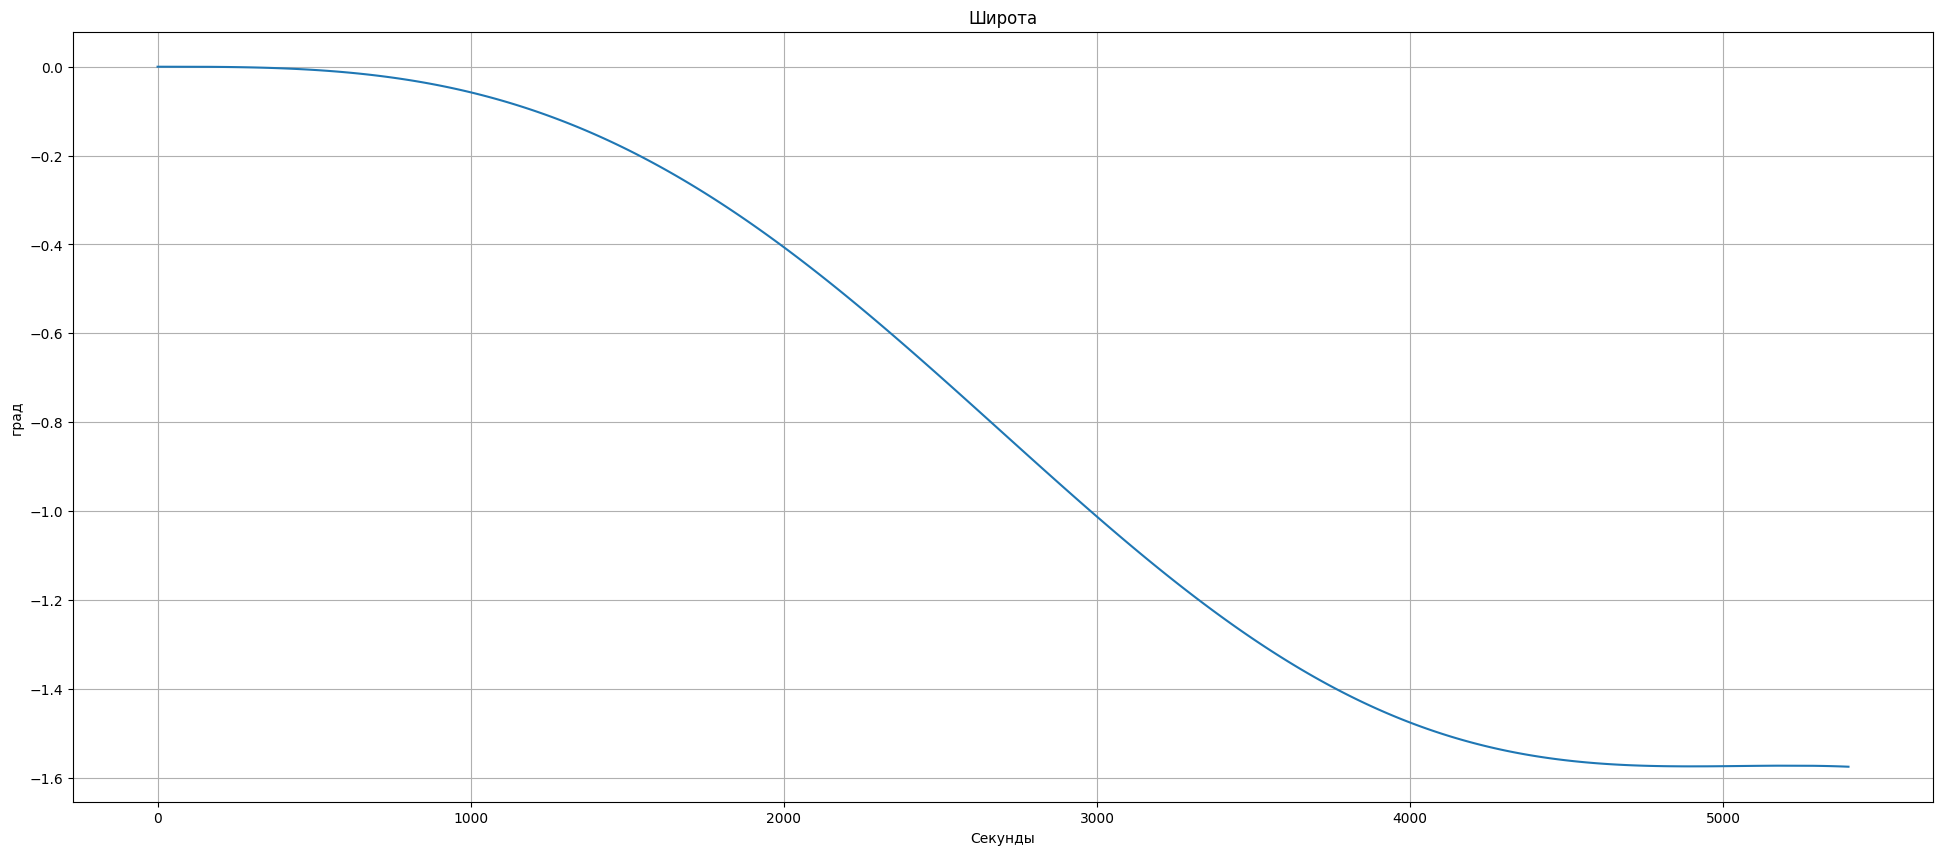

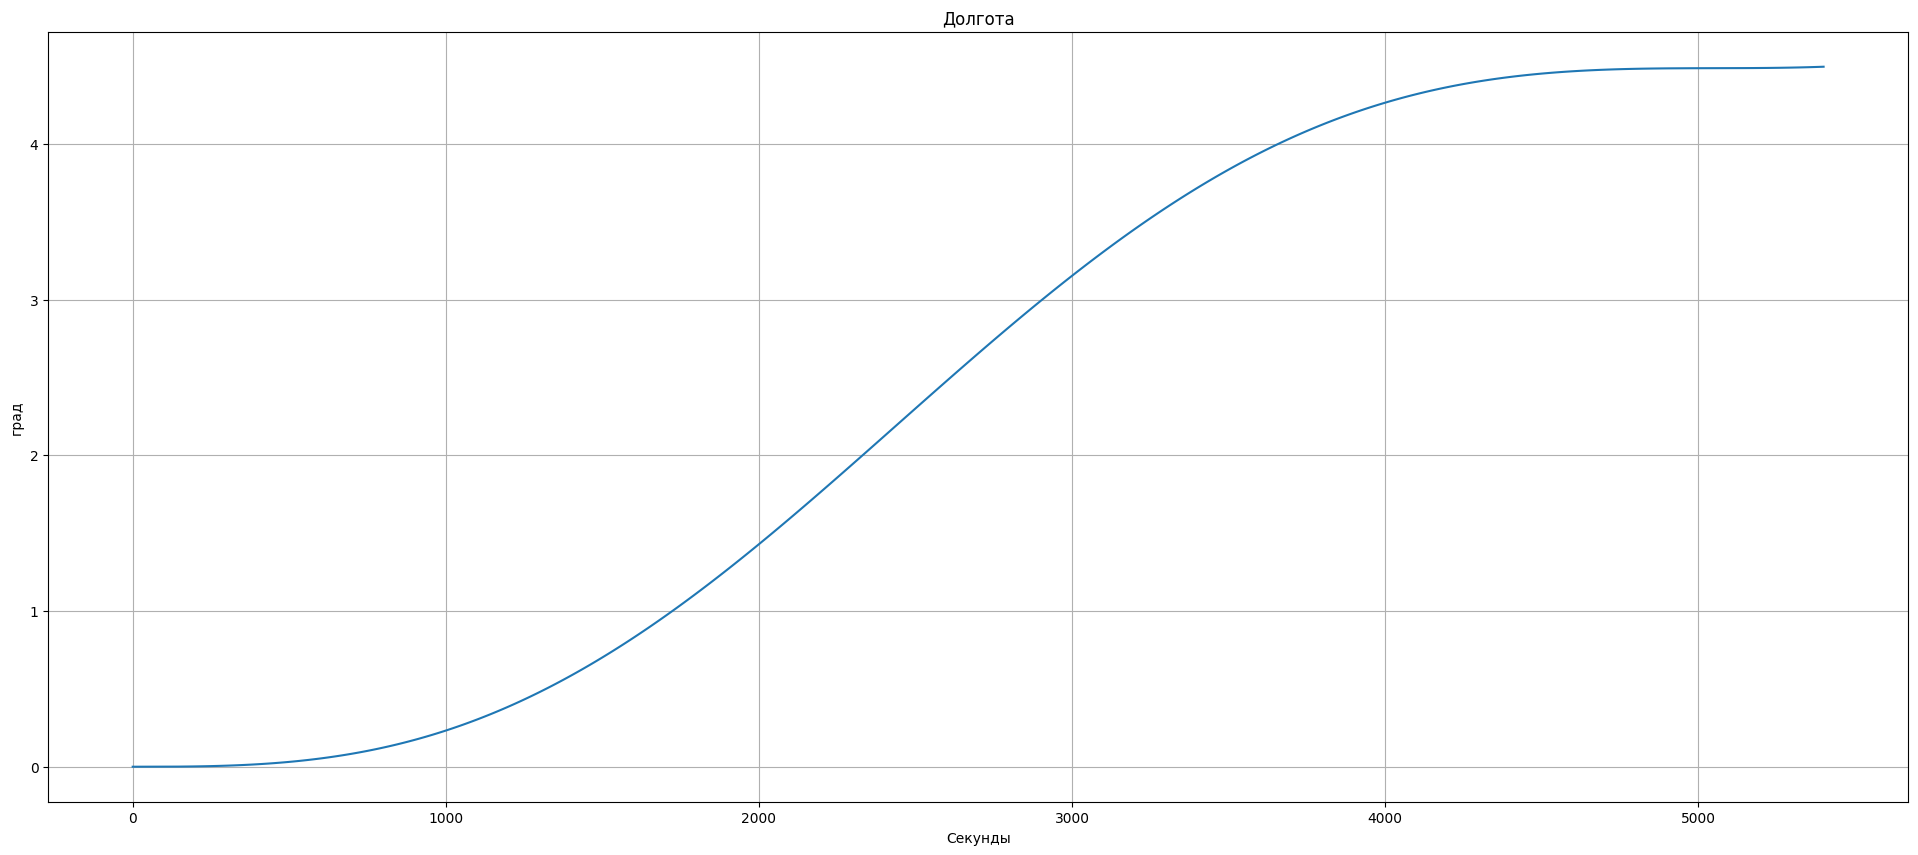

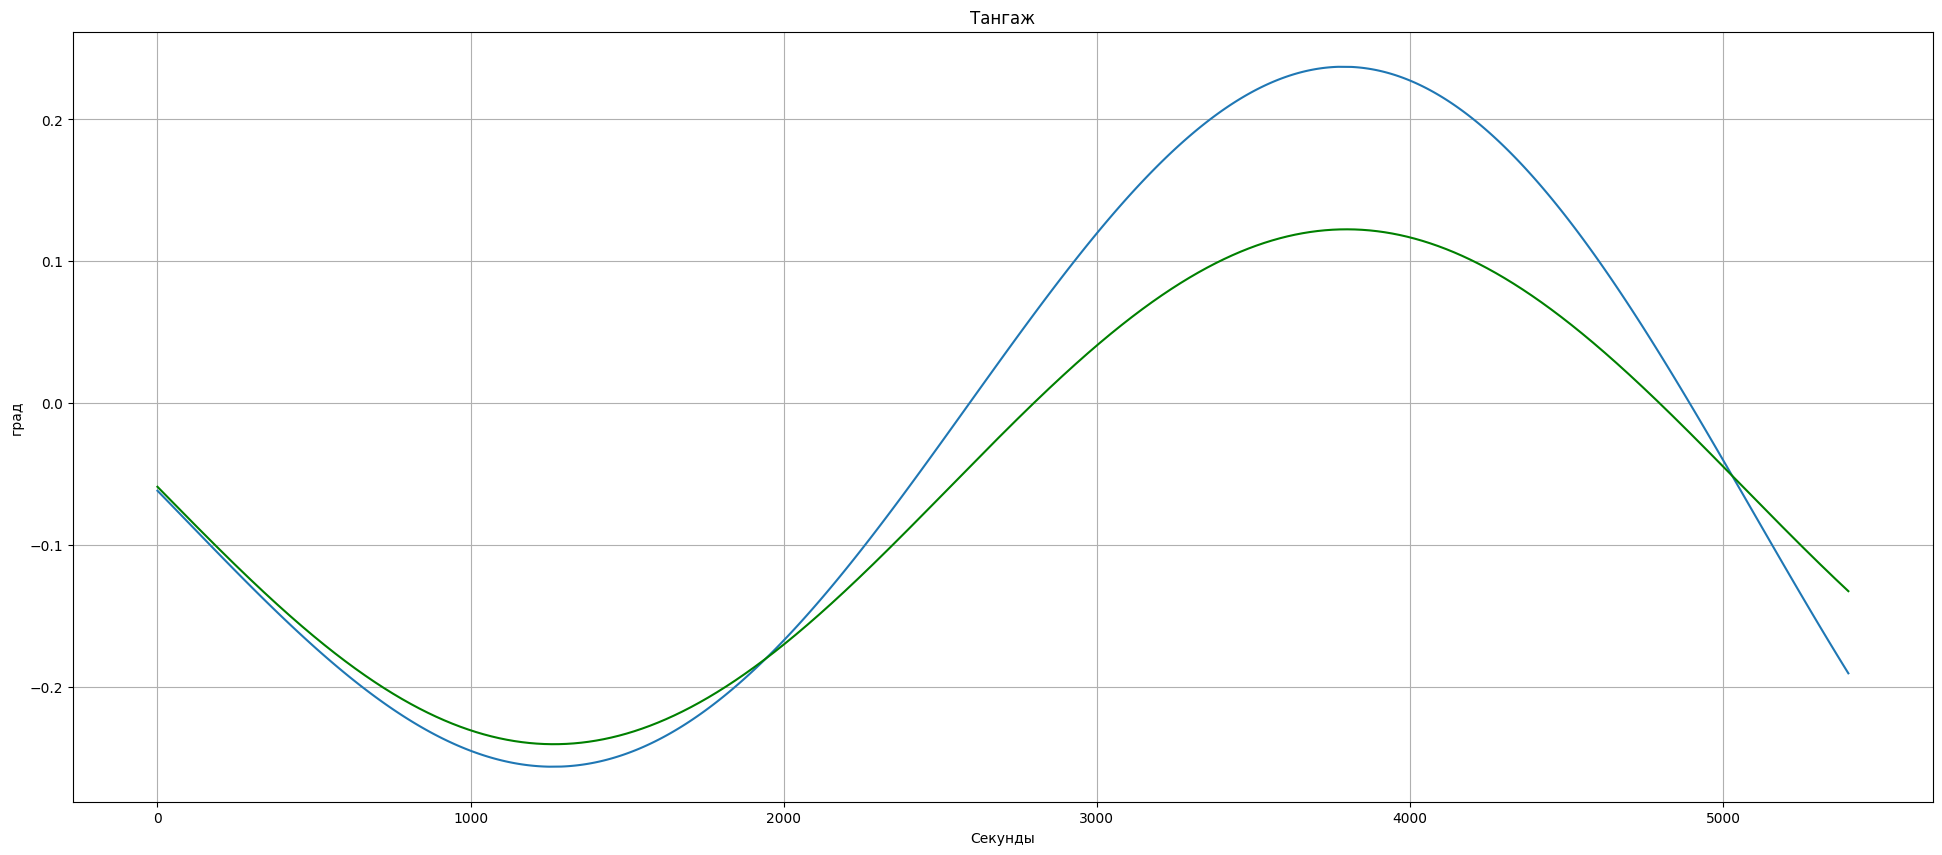

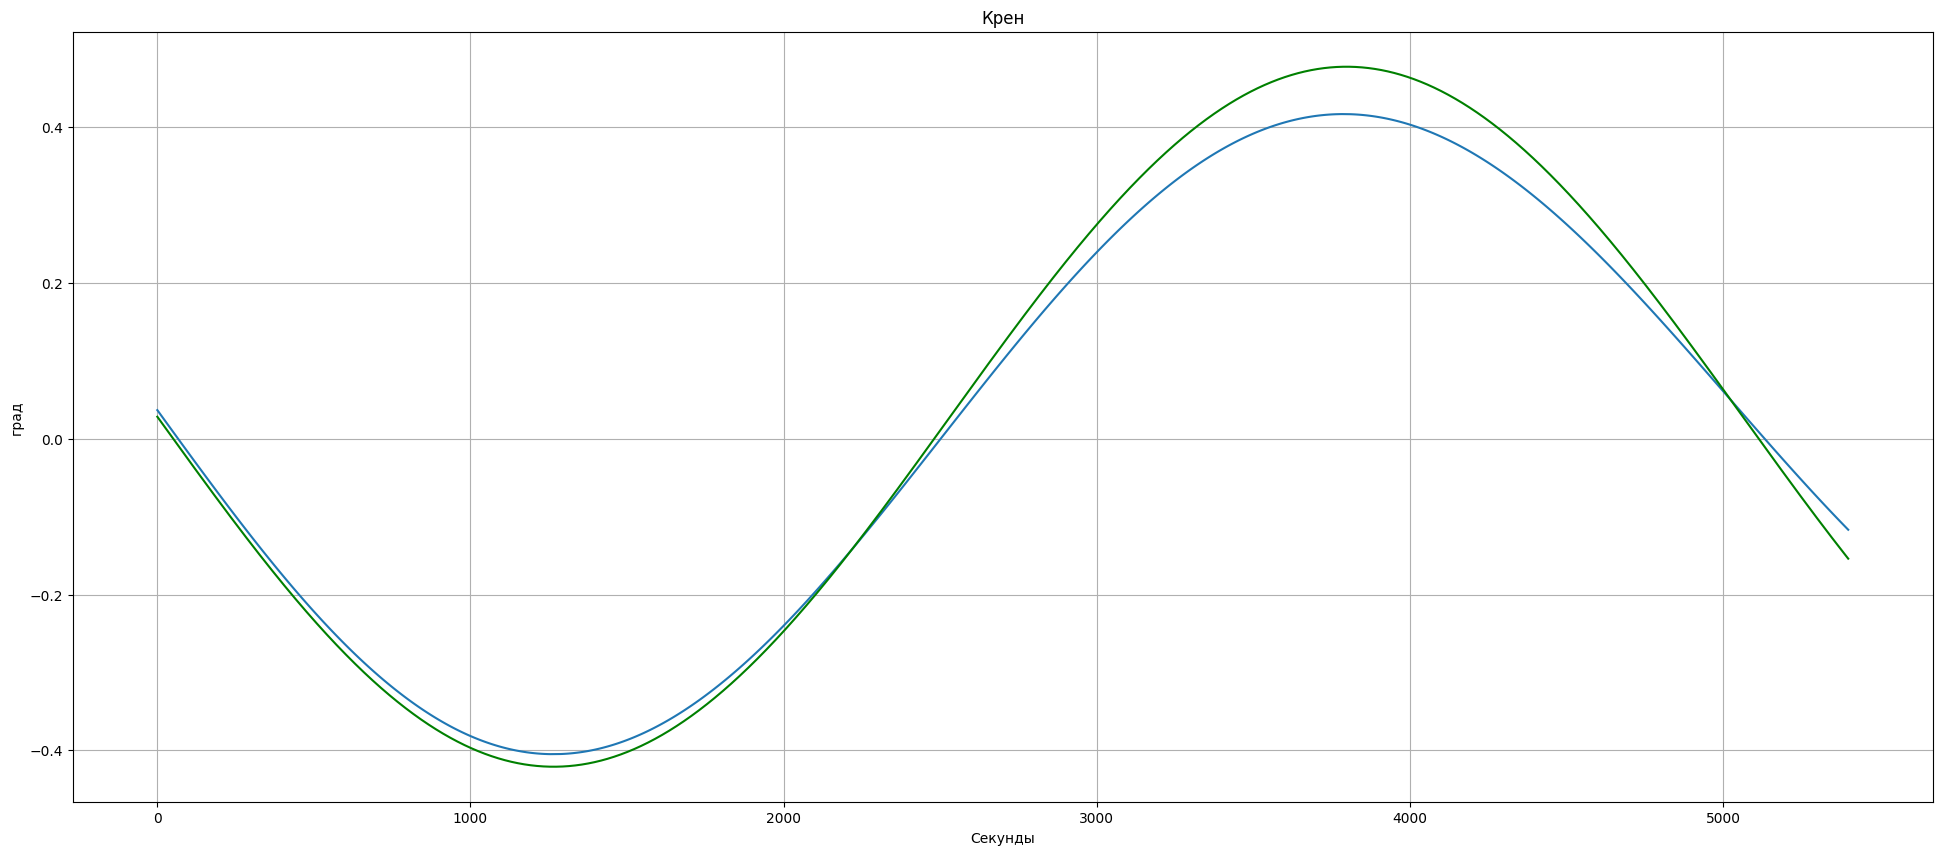

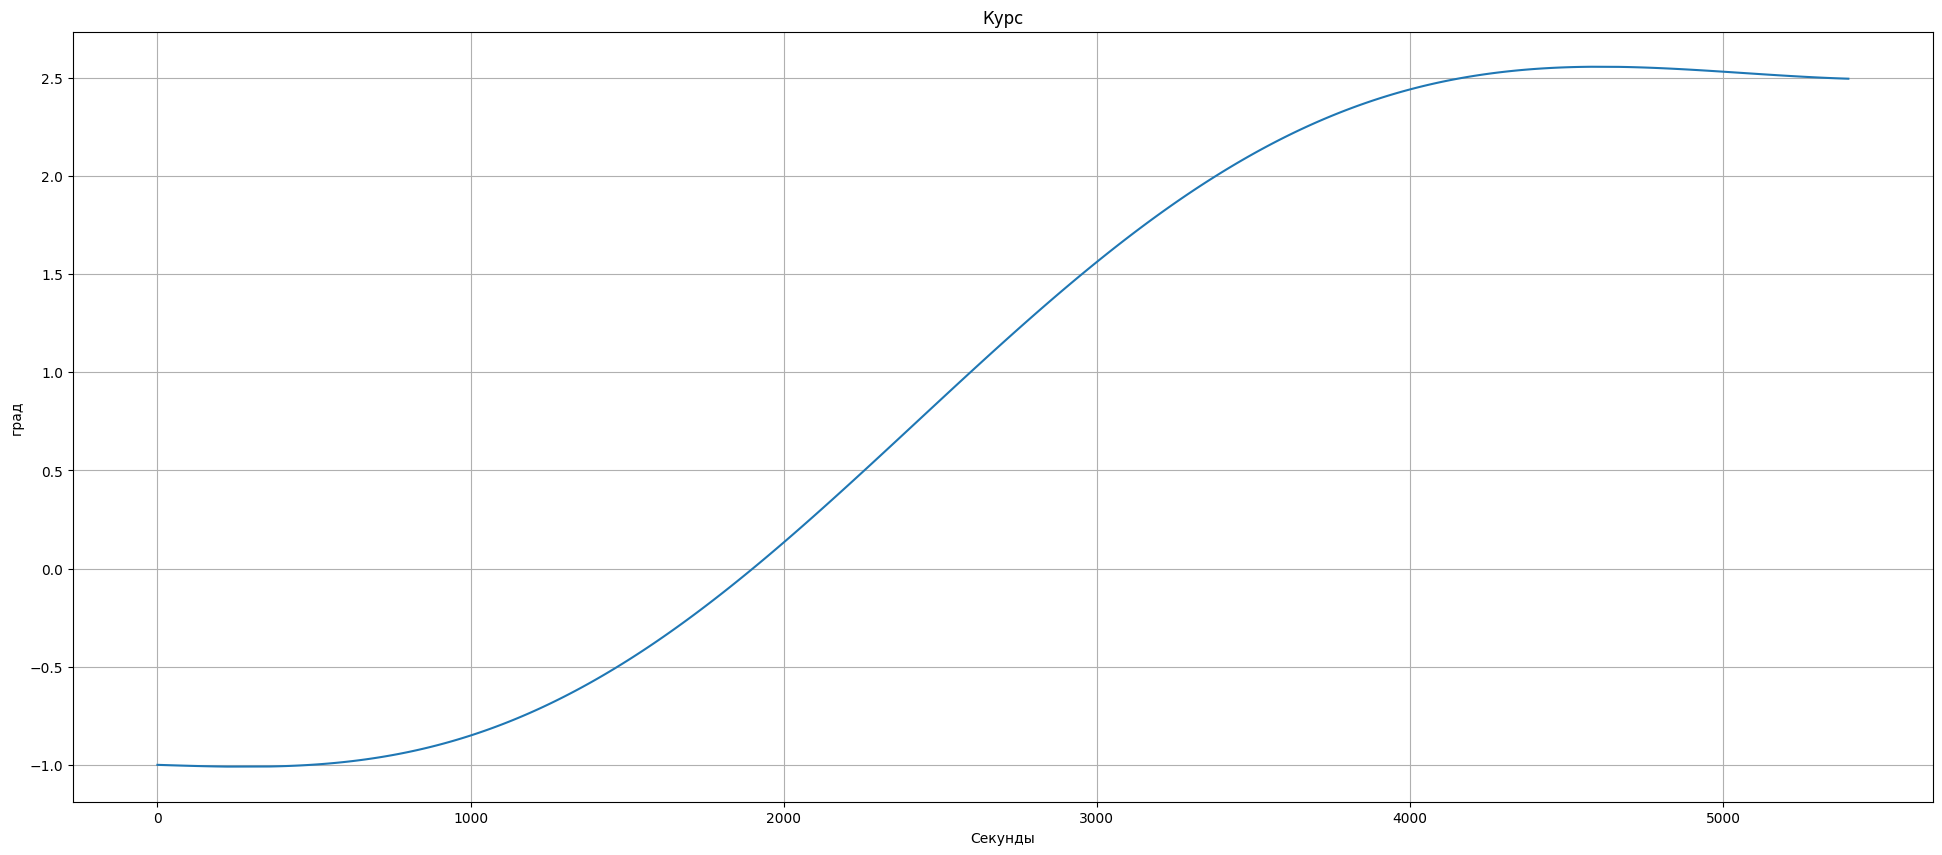

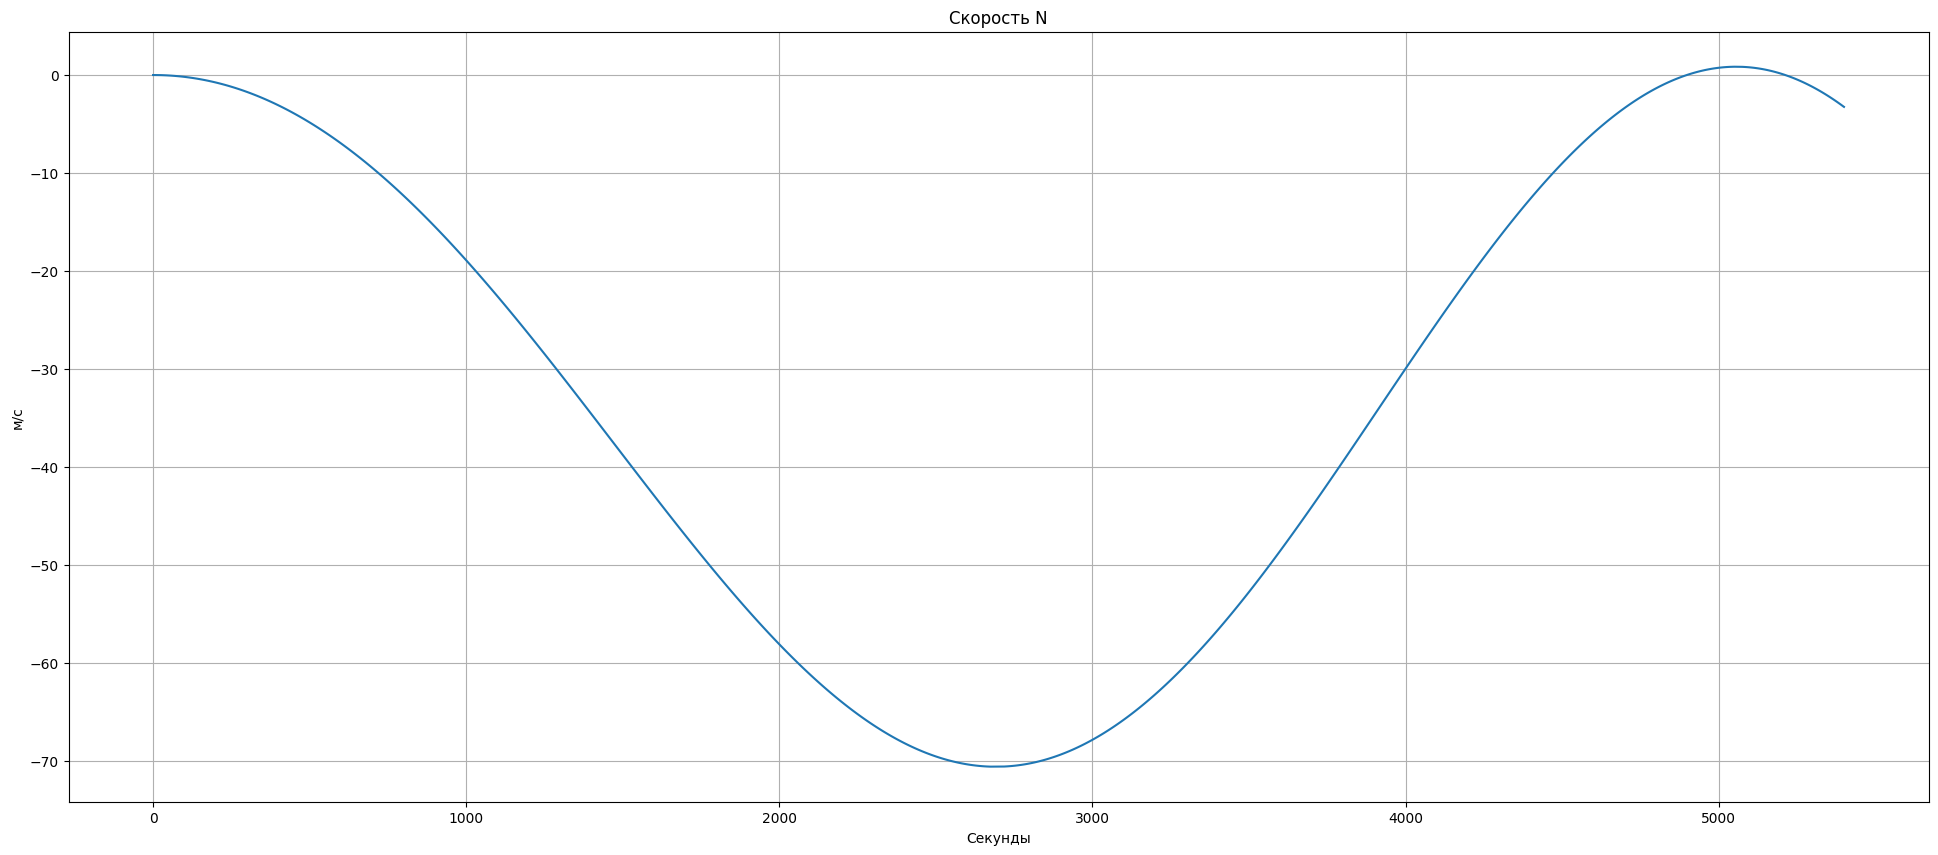

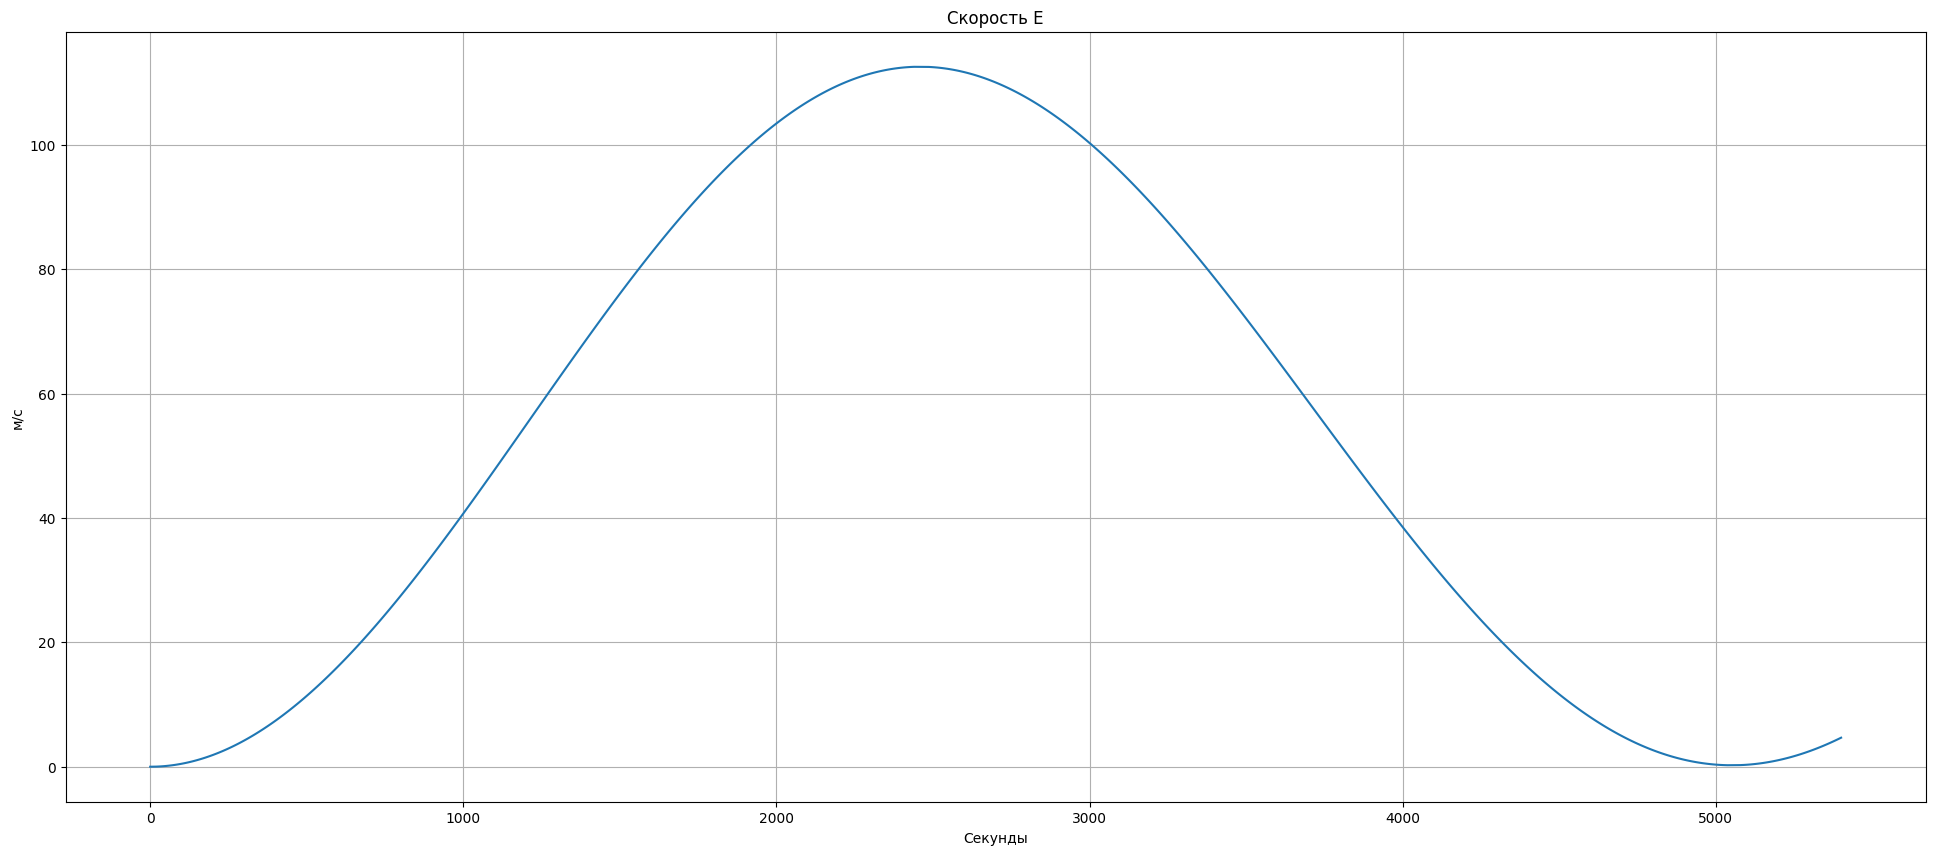

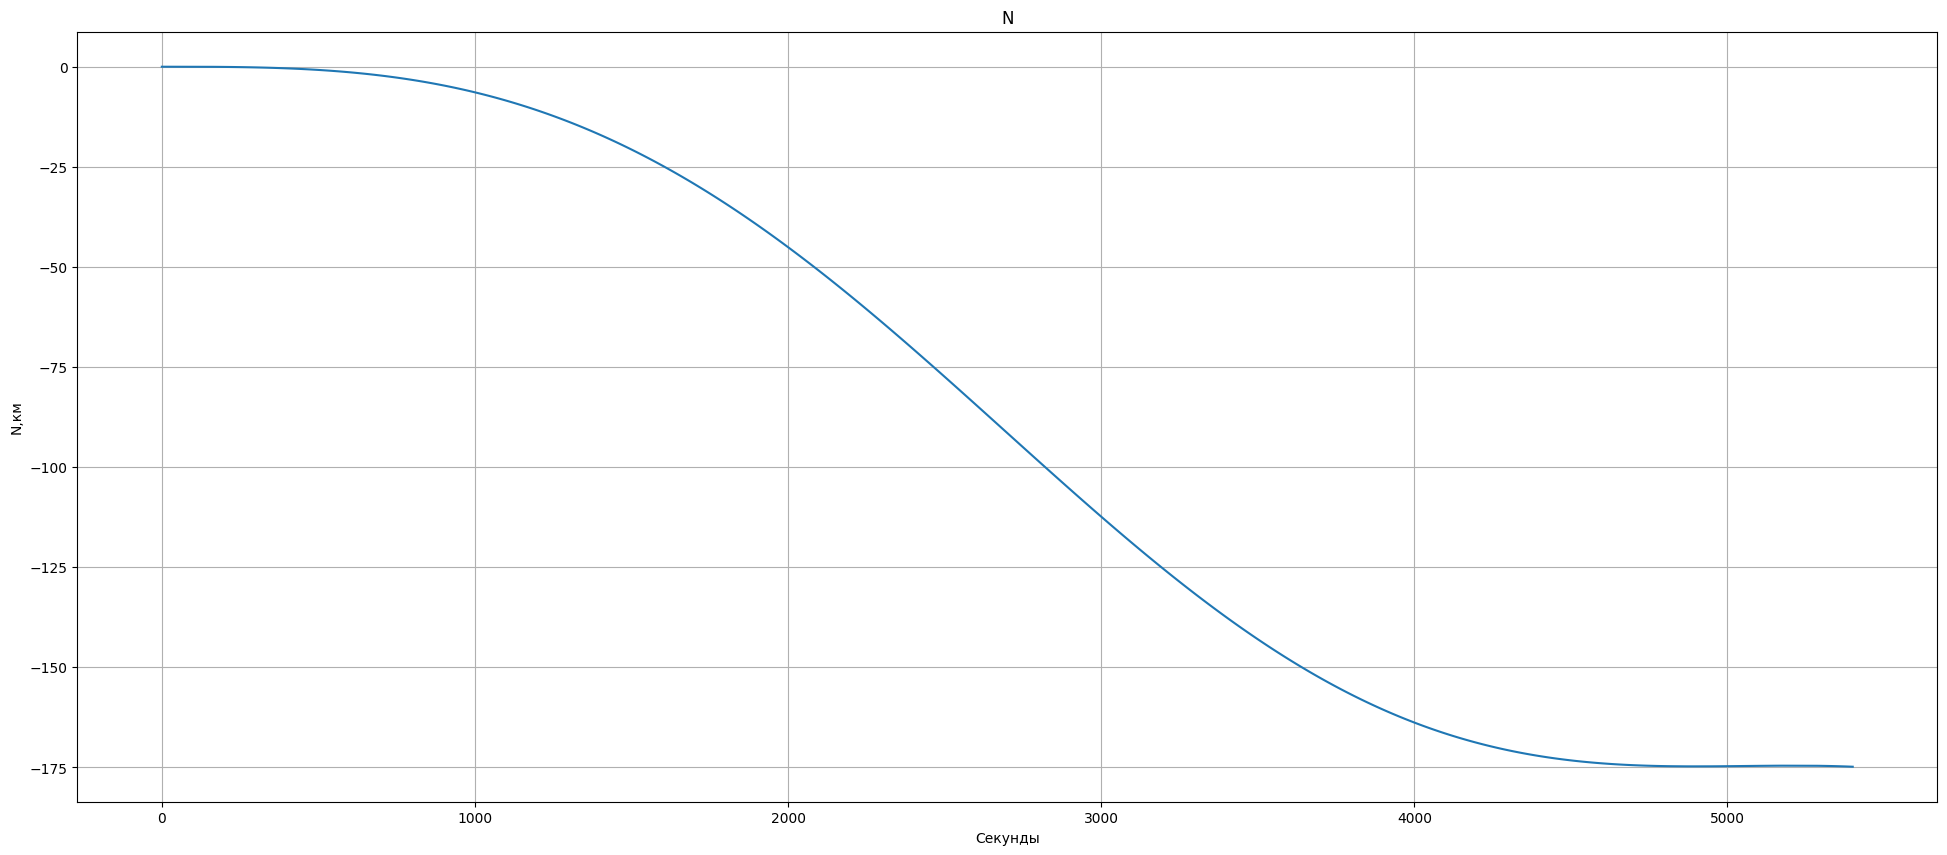

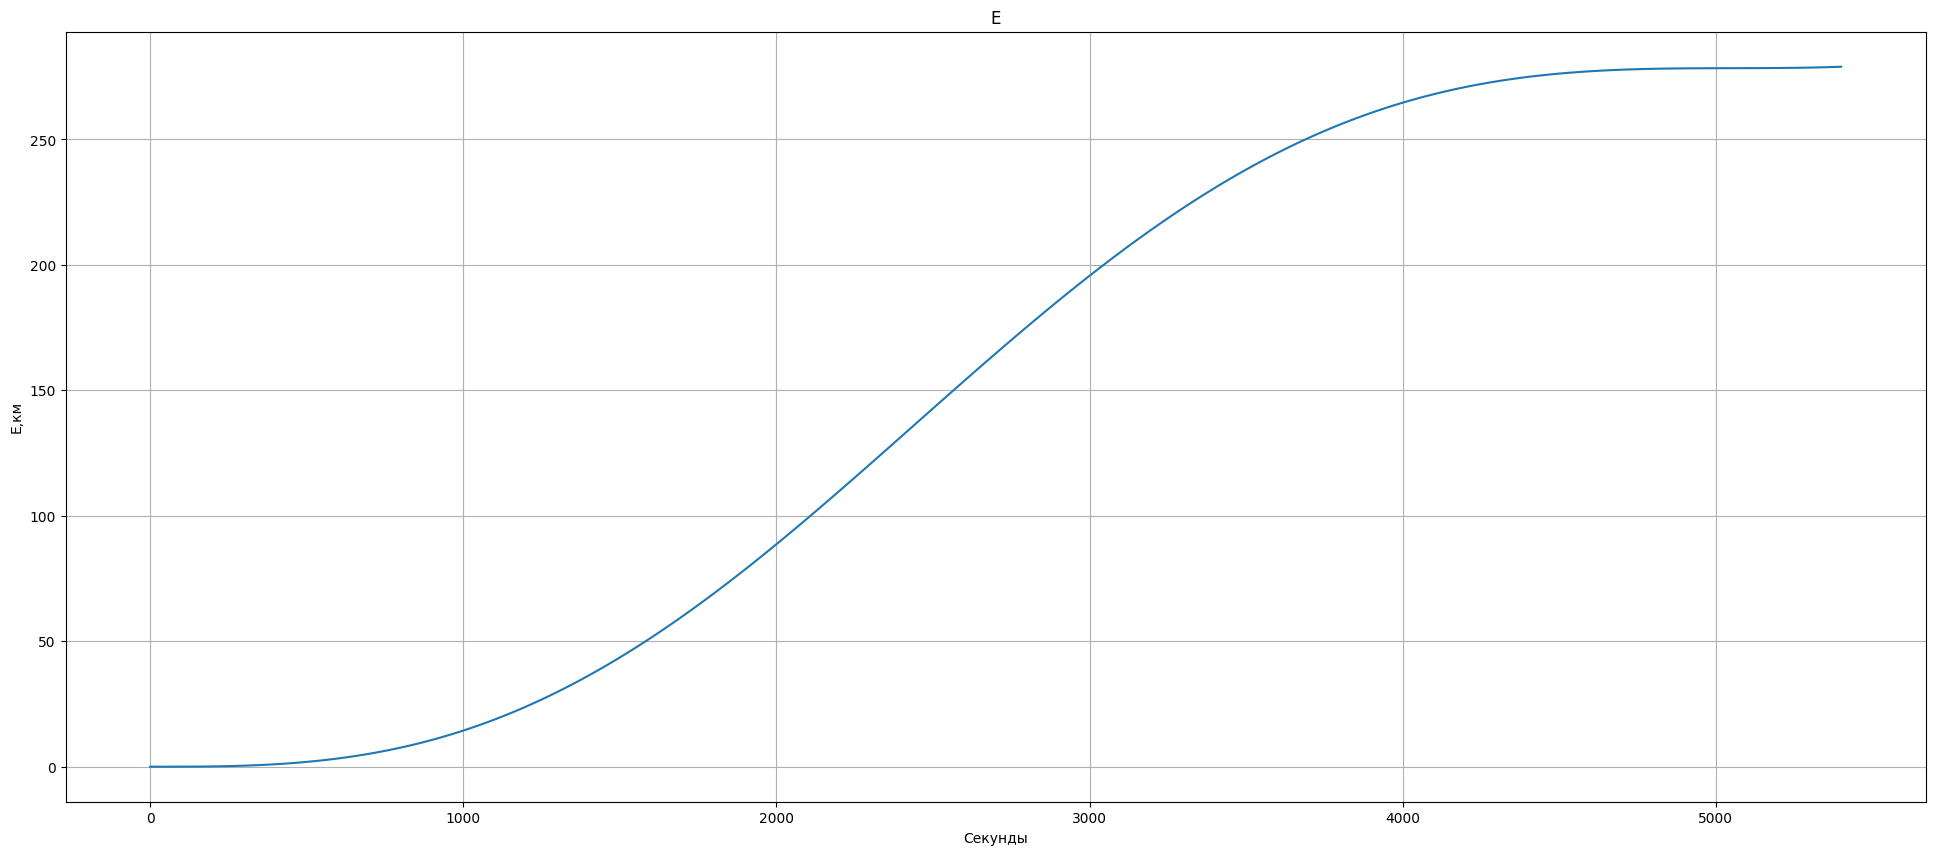

In [59]:
plt.figure(1)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,out_Lat)
plt.title("Широта")
plt.xlabel('Cекунды')
plt.ylabel('град')
plt.grid(True)
plt.show()

plt.figure(2)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,out_Lon)
plt.title("Долгота")
plt.xlabel('Cекунды')
plt.ylabel('град')
plt.grid(True)
plt.show()

plt.figure(3)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,out_pitch,t,-delta_pitch,'g')
plt.title("Тангаж")
plt.xlabel('Cекунды')
plt.ylabel('град')
plt.grid(True)
plt.show()

plt.figure(4)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,out_roll,t,-delta_roll,'g')
plt.title("Крен")
plt.xlabel('Cекунды')
plt.ylabel('град')
plt.grid(True)
plt.show()

plt.figure(5)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,out_heading)
plt.title("Курс")
plt.xlabel('Cекунды')
plt.ylabel('град')
plt.grid(True)
plt.show()

plt.figure(6)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,out_W_N)
plt.title("Скорость N")
plt.xlabel('Cекунды')
plt.ylabel('м/c')
plt.grid(True)
plt.show()

plt.figure(7)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,out_W_E)
plt.title("Скорость E")
plt.xlabel('Cекунды')
plt.ylabel('м/c')
plt.grid(True)
plt.show()

R = 6356.863 # км
queue_x = (out_Lat * ((np.pi / 180) * R)) - (out_Lat[0] * ((np.pi / 180) * R))
queue_y = (out_Lon * (np.pi / 180) * (R * np.cos(Lat))) - (out_Lon[0] * np.pi / 180 * (R * np.cos(Lat)))

plt.figure(8)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,queue_x)
plt.title("N")
plt.xlabel('Cекунды')
plt.ylabel('N,км')
plt.grid(True)
plt.show()

plt.figure(9)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,queue_y)
plt.title("E")
plt.xlabel('Cекунды')
plt.ylabel('E,км')
plt.grid(True)
plt.show()

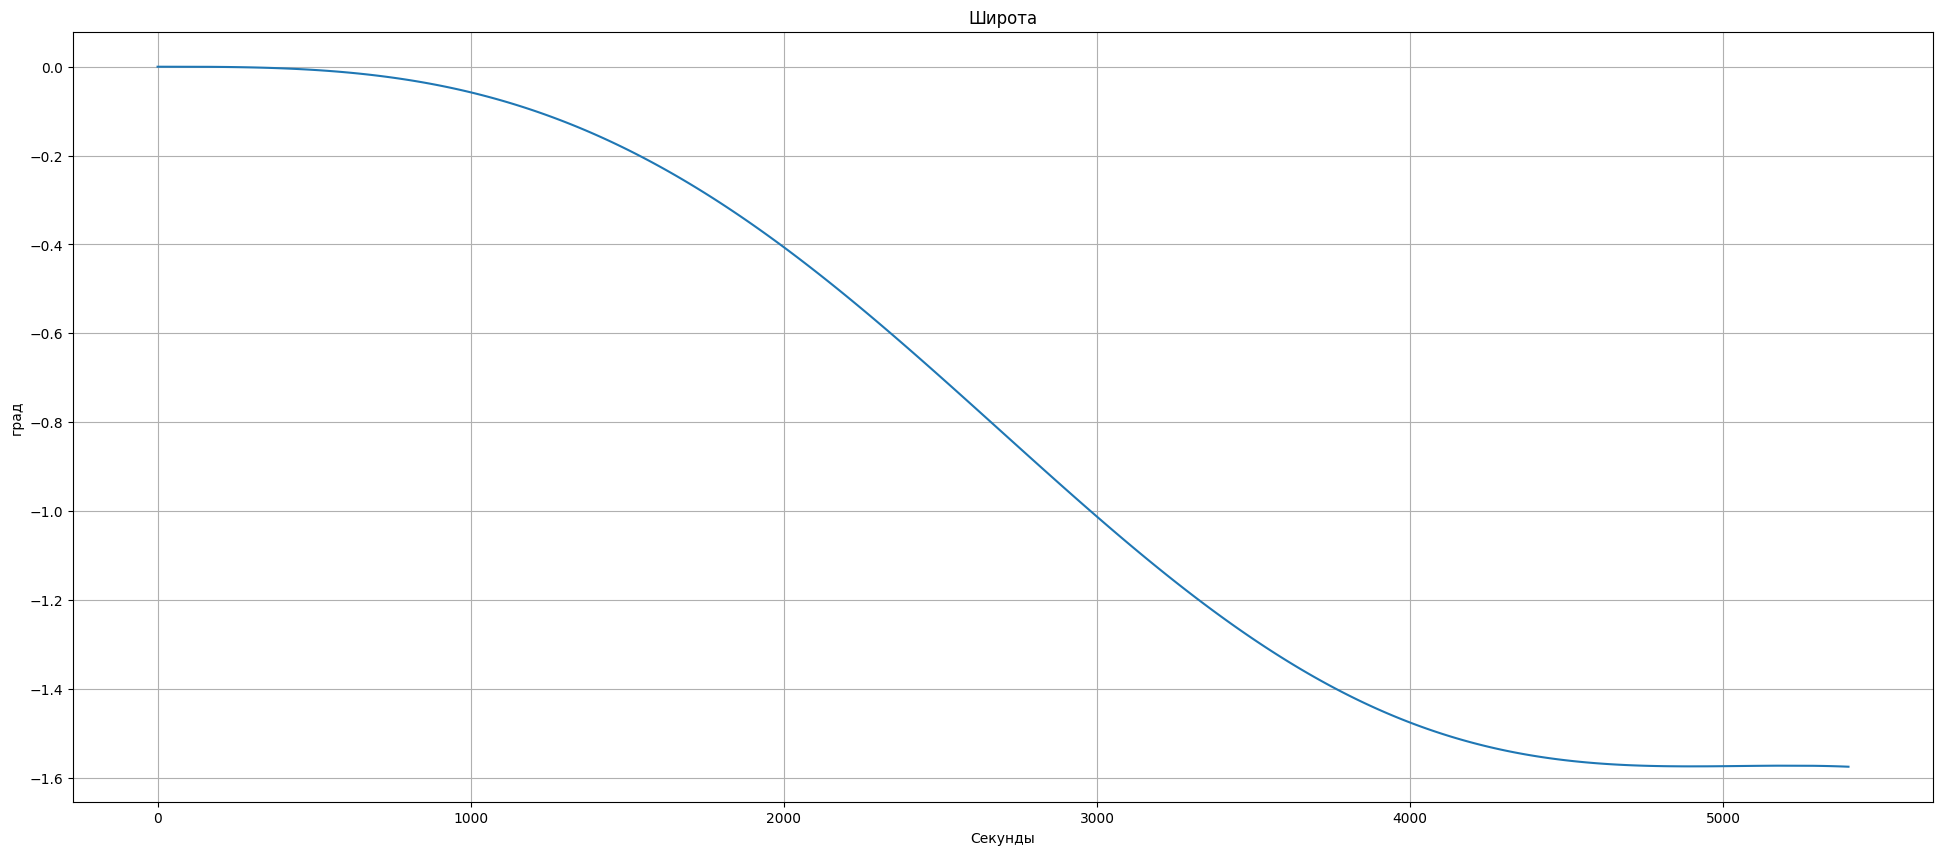

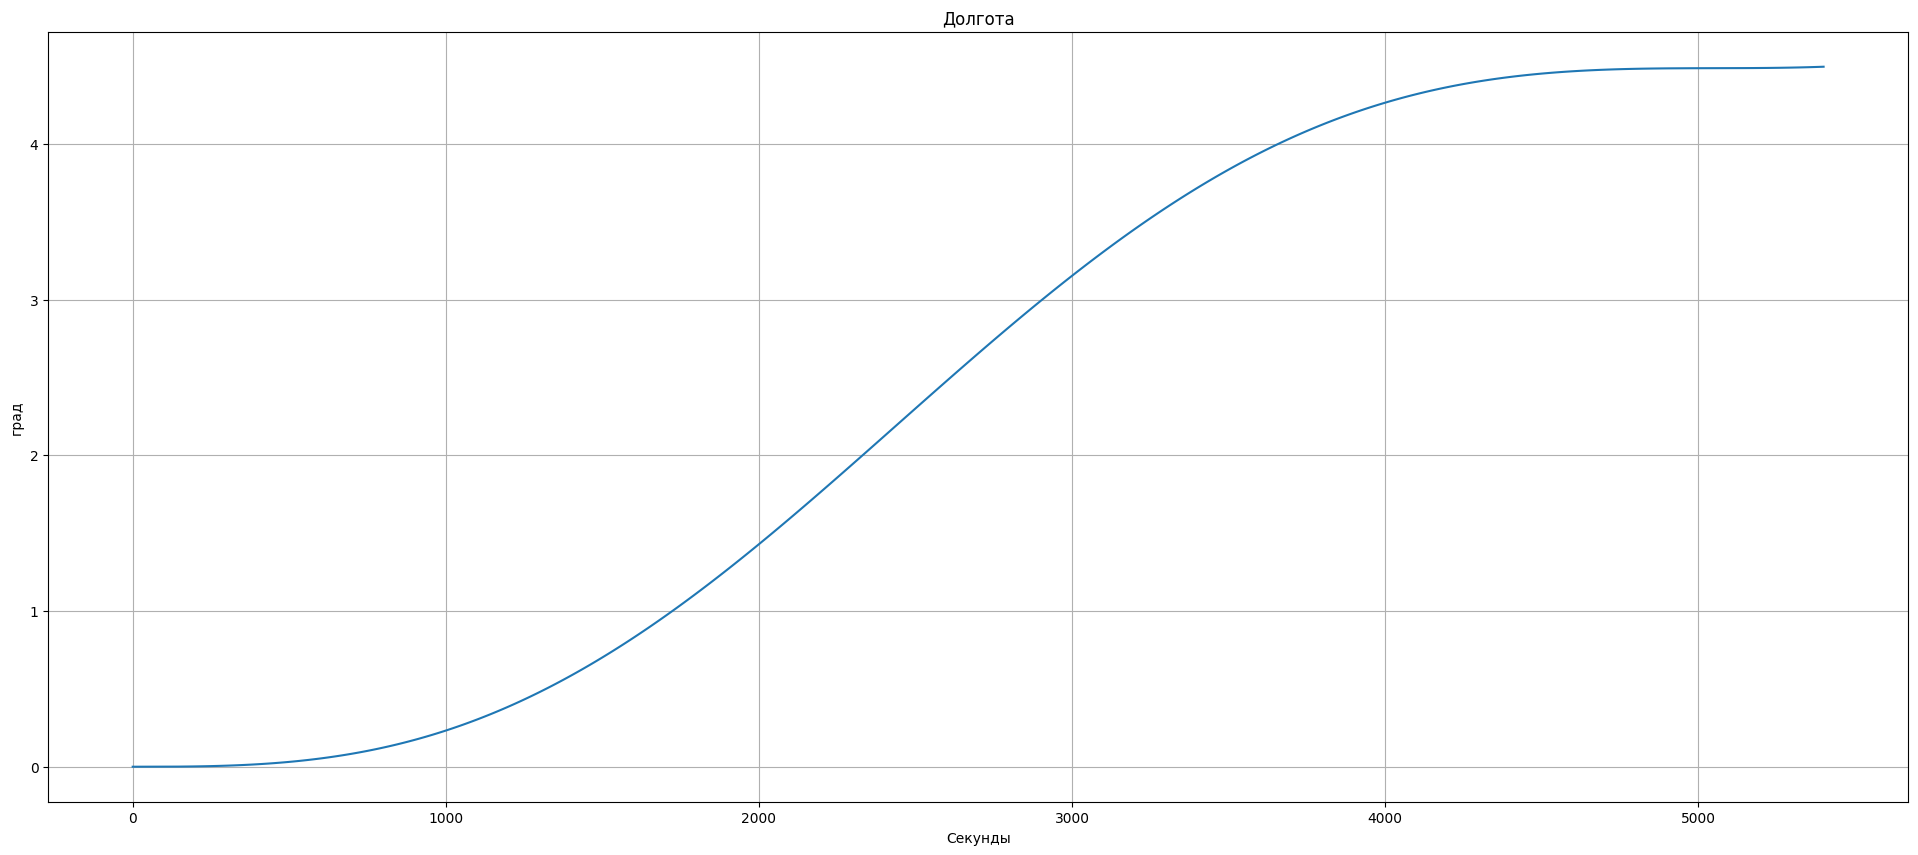

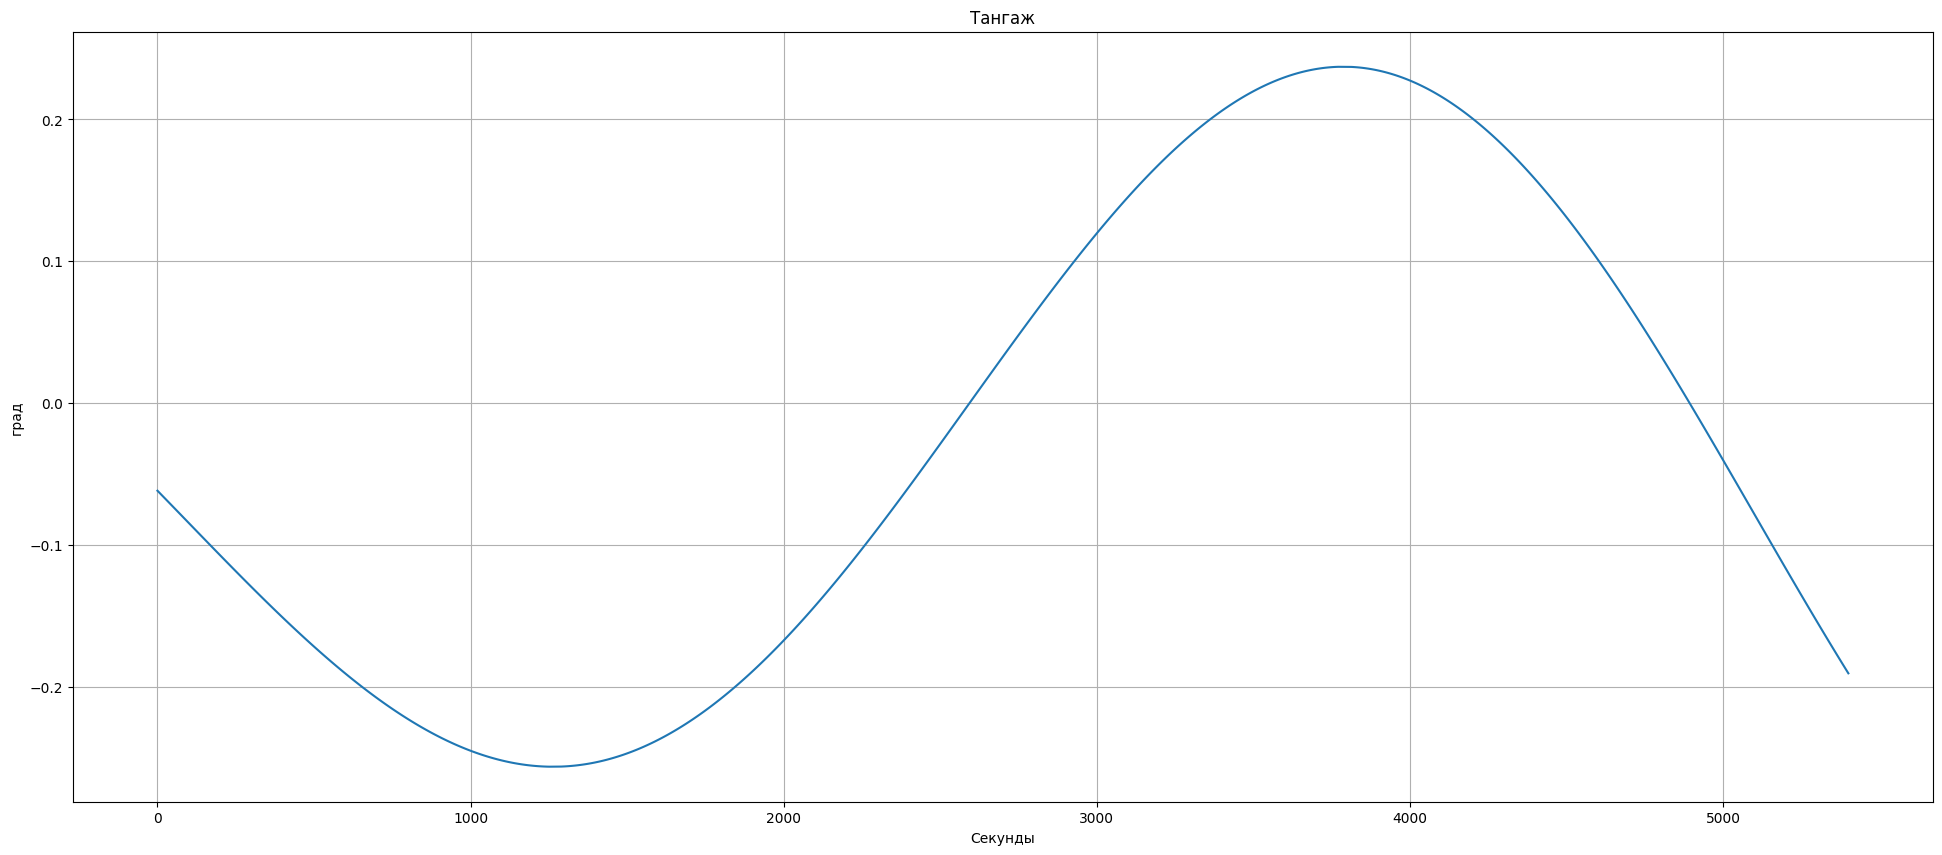

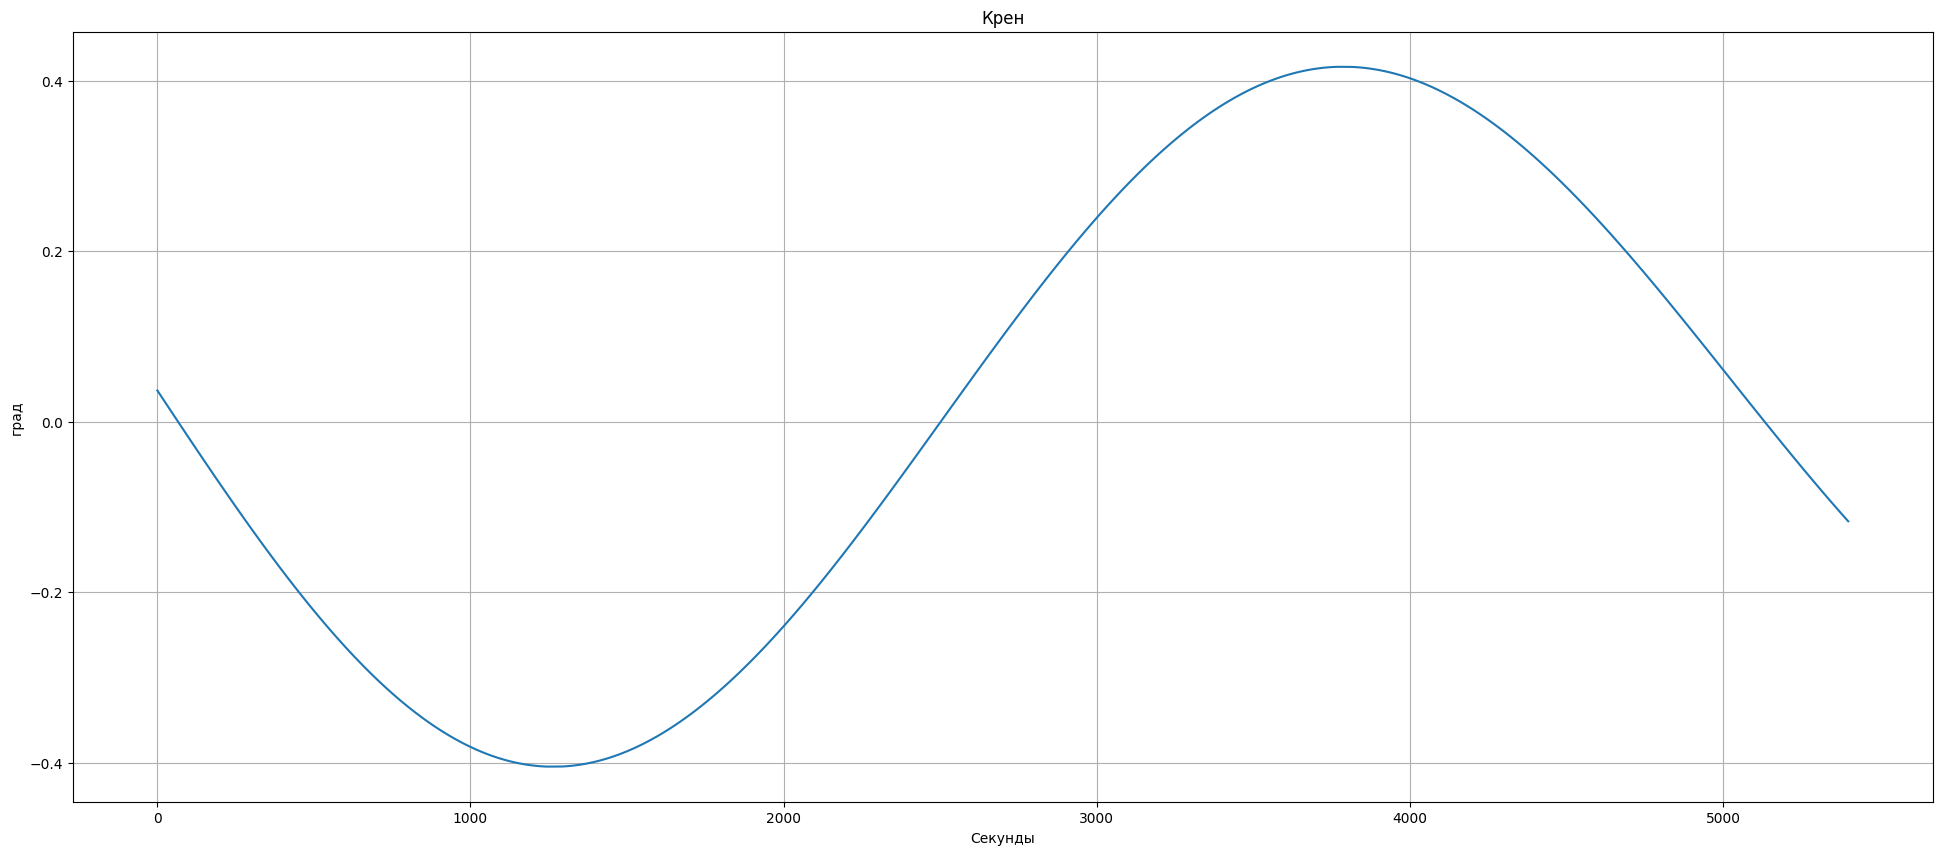

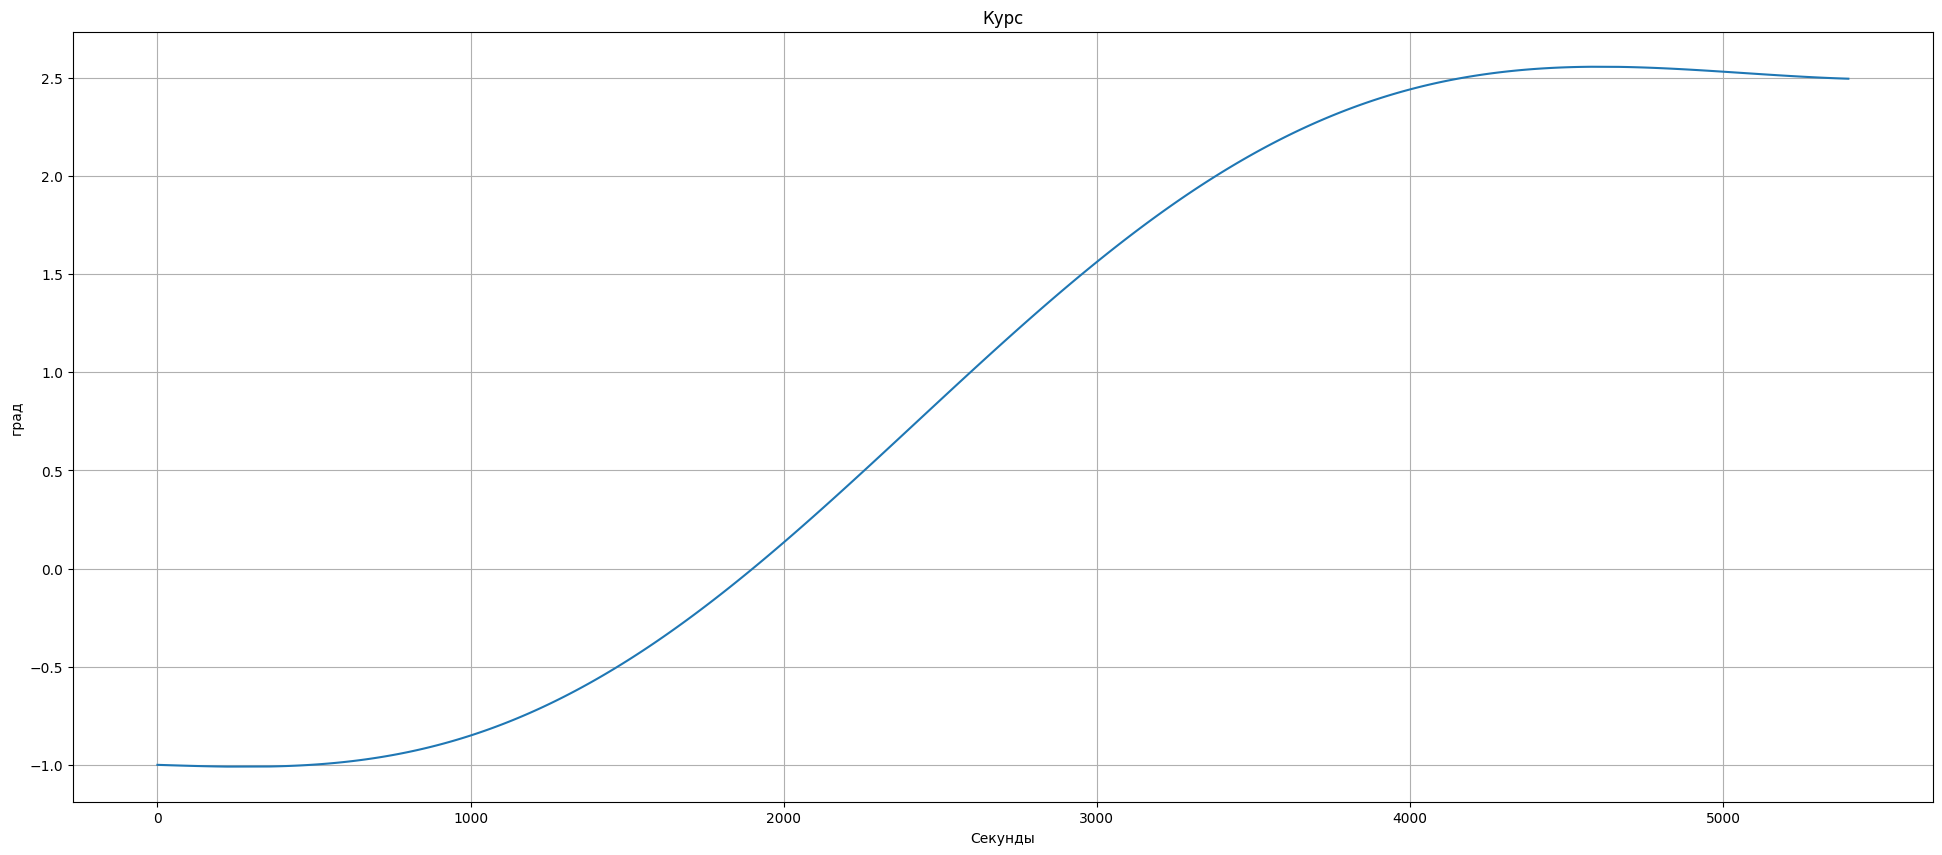

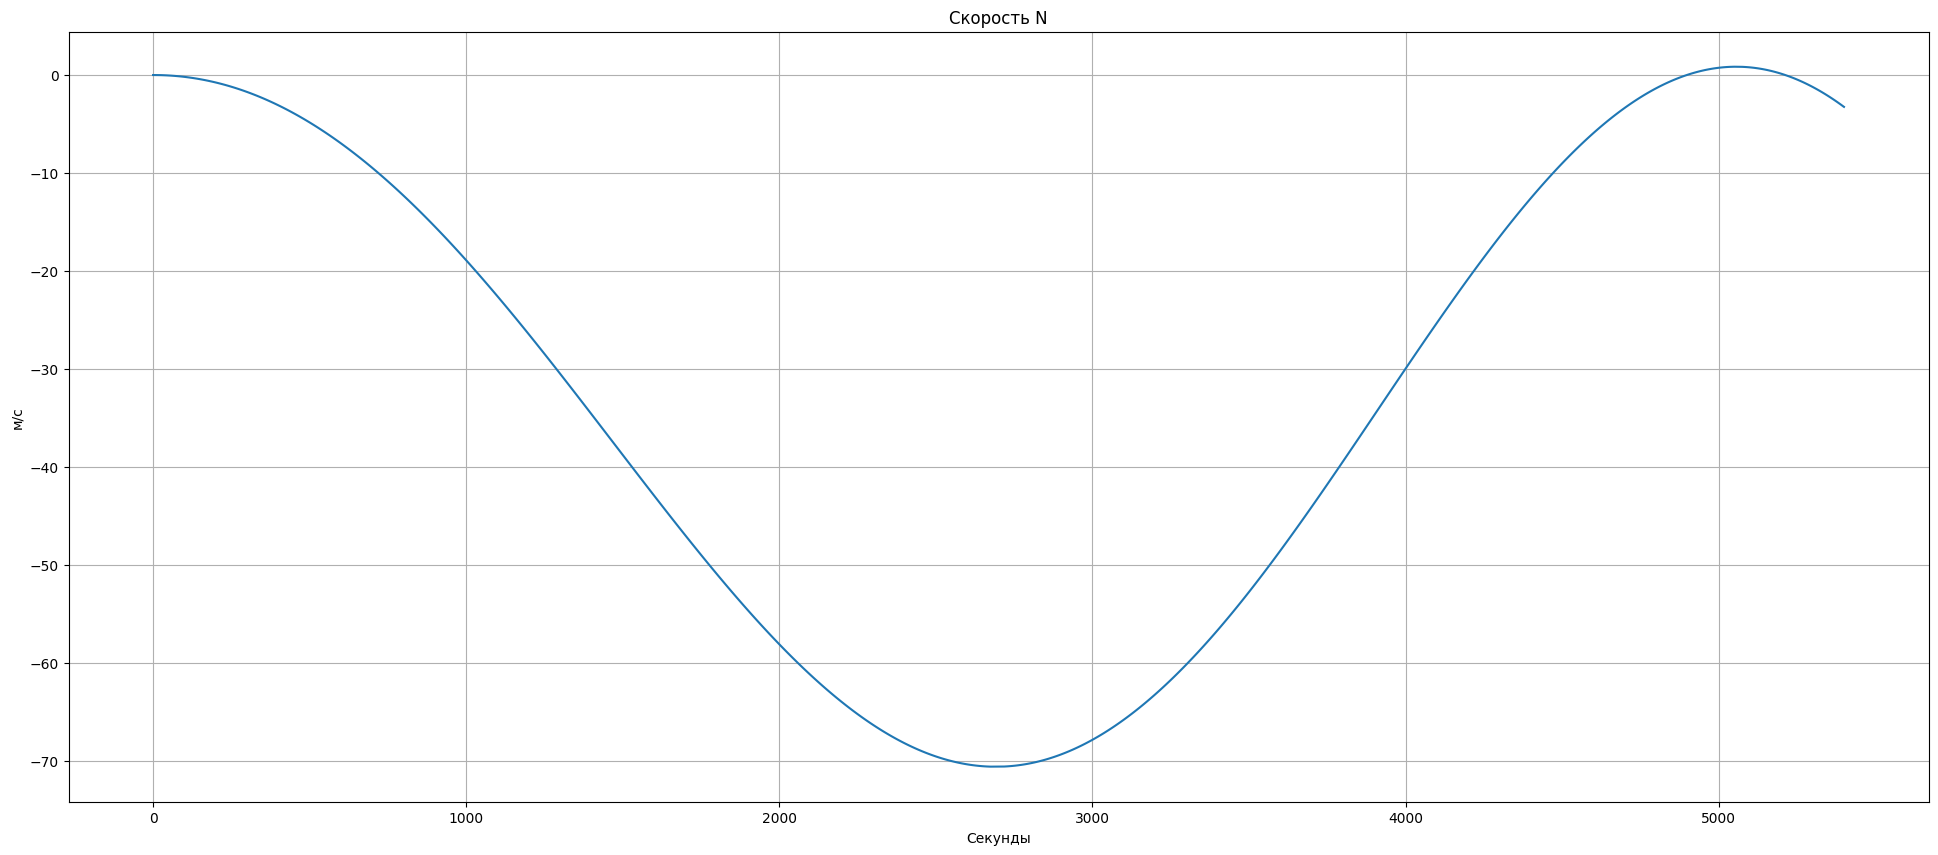

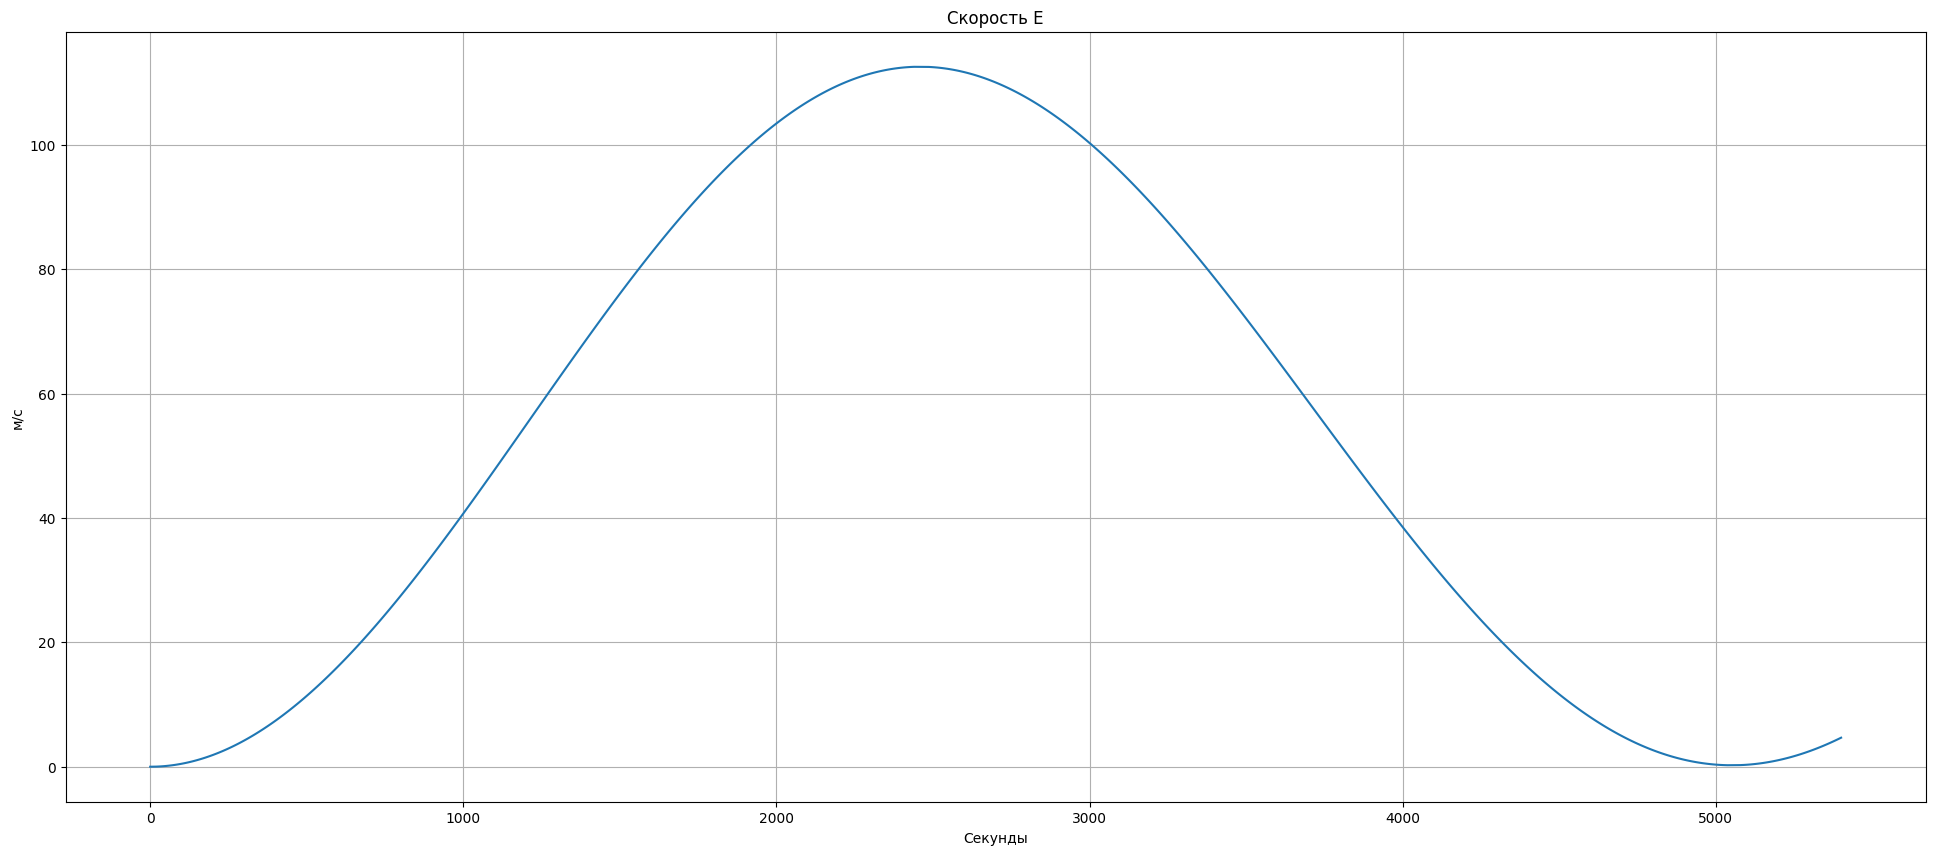

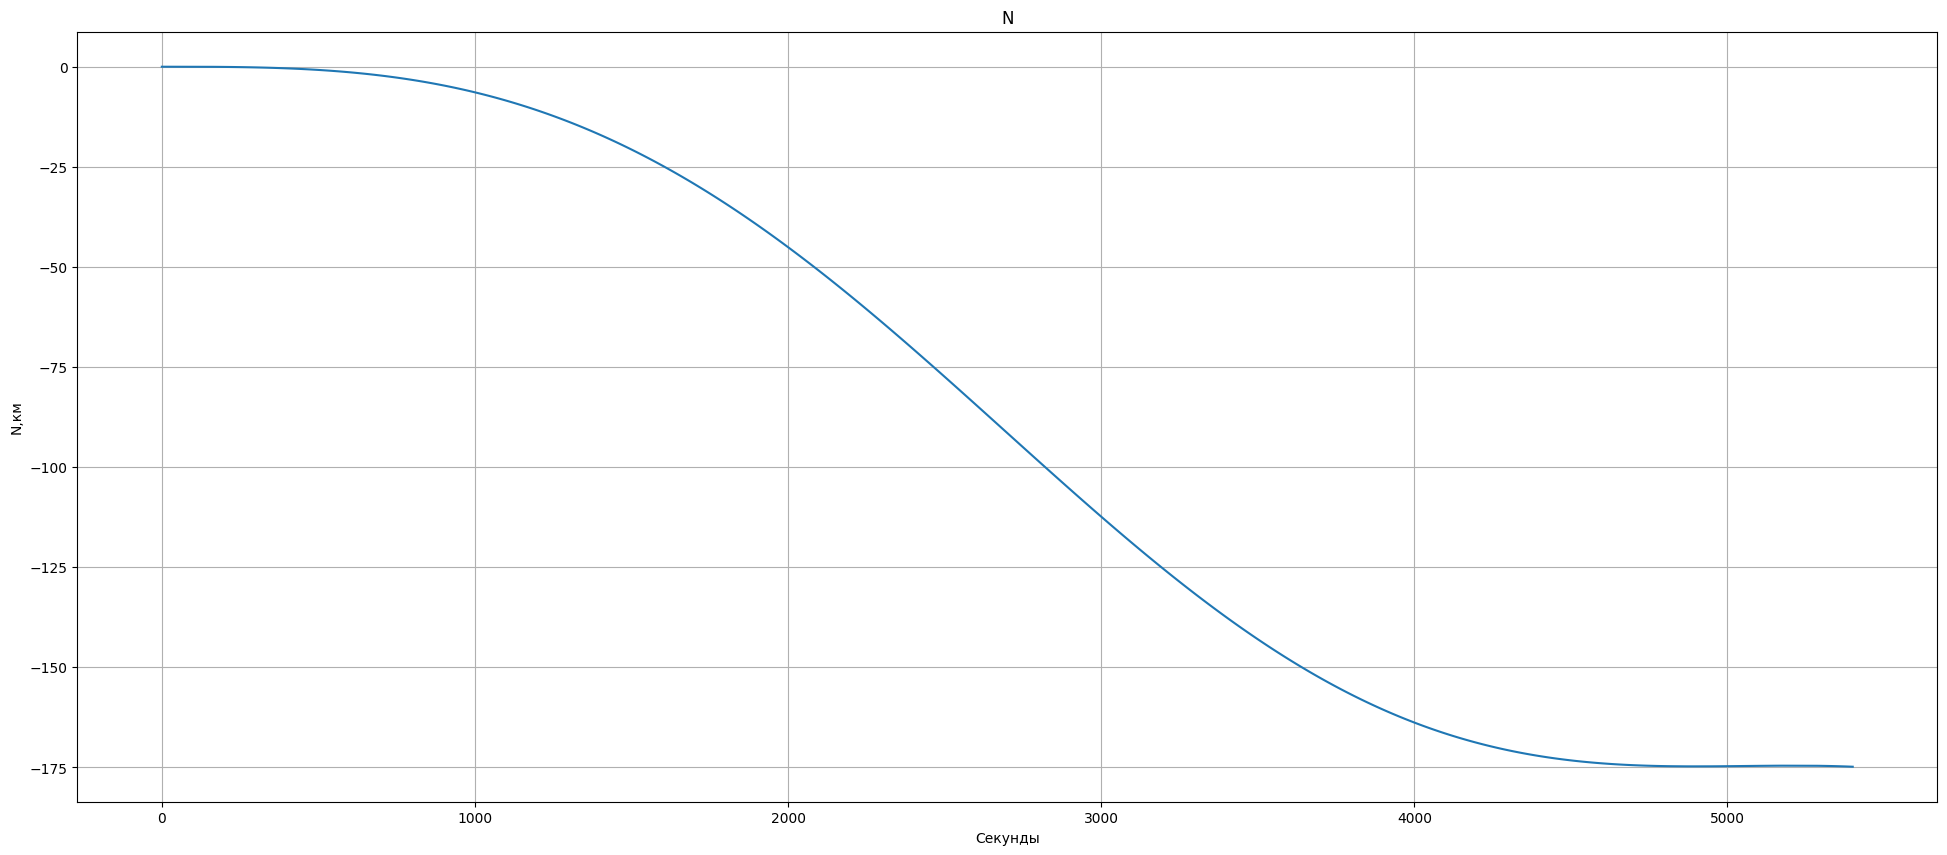

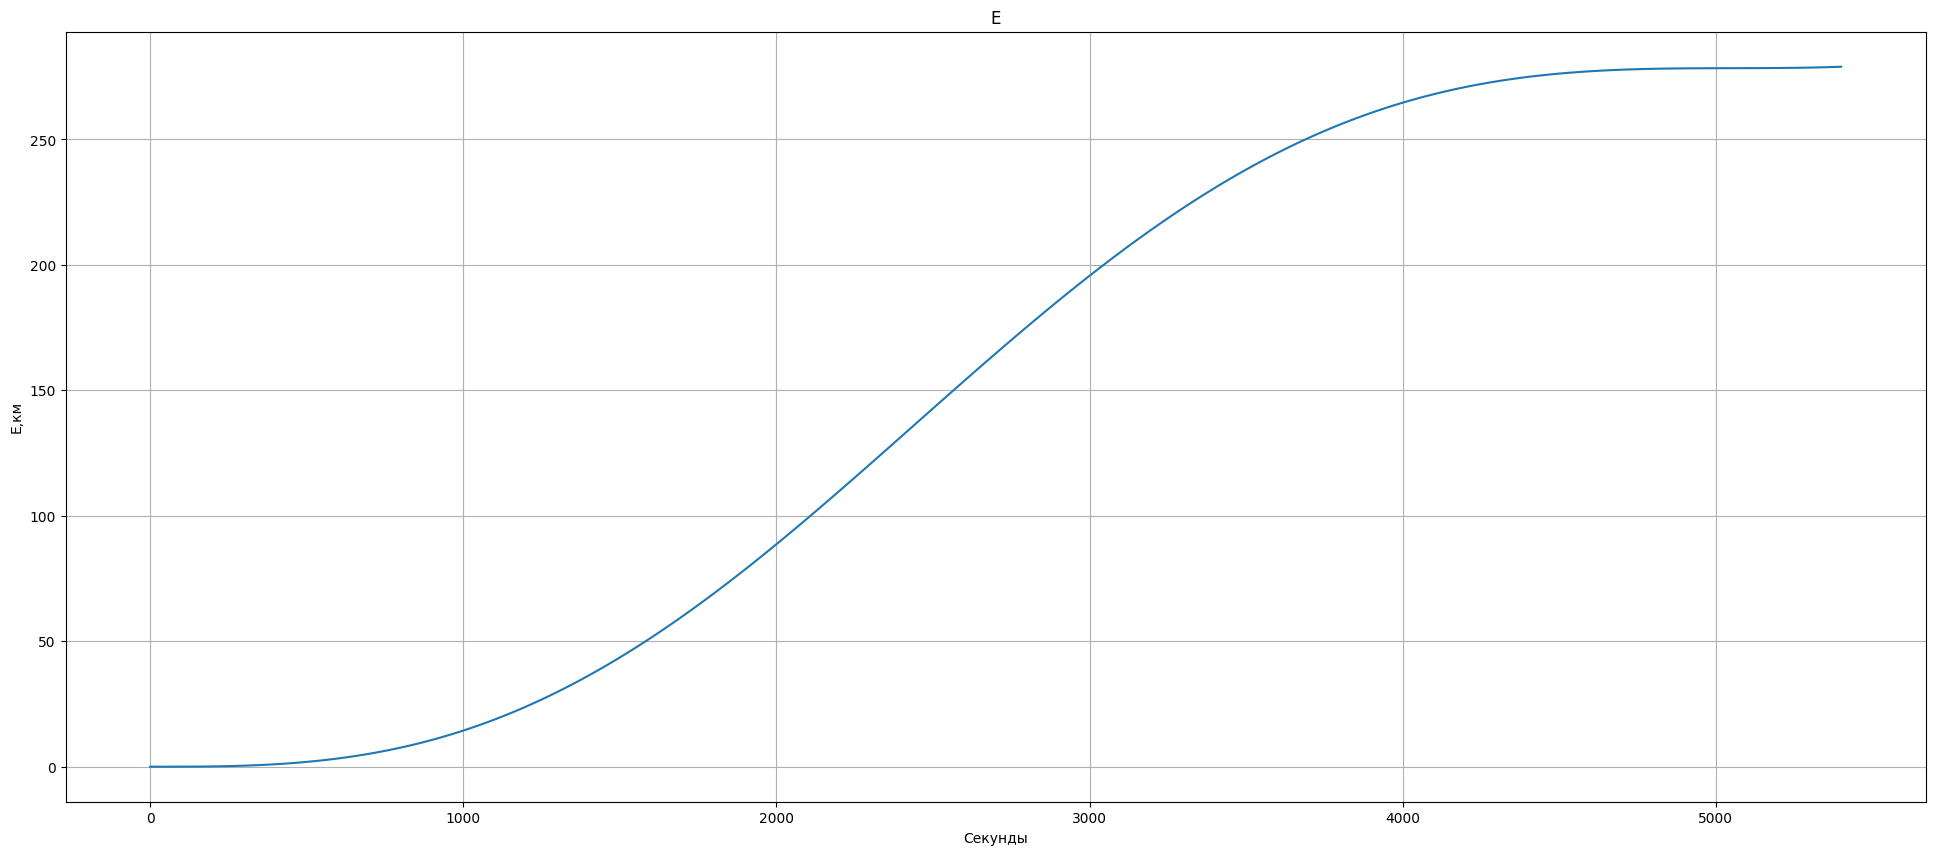

In [58]:
plt.figure(1)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,out_Lat)
plt.title("Широта")
plt.xlabel('Cекунды')
plt.ylabel('град')
plt.grid(True)
plt.show()

plt.figure(2)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,out_Lon)
plt.title("Долгота")
plt.xlabel('Cекунды')
plt.ylabel('град')
plt.grid(True)
plt.show()

plt.figure(3)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,out_pitch)
plt.title("Тангаж")
plt.xlabel('Cекунды')
plt.ylabel('град')
plt.grid(True)
plt.show()

plt.figure(4)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,out_roll)
plt.title("Крен")
plt.xlabel('Cекунды')
plt.ylabel('град')
plt.grid(True)
plt.show()

plt.figure(5)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,out_heading)
plt.title("Курс")
plt.xlabel('Cекунды')
plt.ylabel('град')
plt.grid(True)
plt.show()

plt.figure(6)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,out_W_N)
plt.title("Скорость N")
plt.xlabel('Cекунды')
plt.ylabel('м/c')
plt.grid(True)
plt.show()

plt.figure(7)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,out_W_E)
plt.title("Скорость E")
plt.xlabel('Cекунды')
plt.ylabel('м/c')
plt.grid(True)
plt.show()

R = 6356.863 # км
queue_x = (out_Lat * ((np.pi / 180) * R)) - (out_Lat[0] * ((np.pi / 180) * R))
queue_y = (out_Lon * (np.pi / 180) * (R * np.cos(Lat))) - (out_Lon[0] * np.pi / 180 * (R * np.cos(Lat)))

plt.figure(8)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,queue_x)
plt.title("N")
plt.xlabel('Cекунды')
plt.ylabel('N,км')
plt.grid(True)
plt.show()

plt.figure(9)
fig = plt.gcf()
fig.set_size_inches(24, 10)
plt.plot(t,queue_y)
plt.title("E")
plt.xlabel('Cекунды')
plt.ylabel('E,км')
plt.grid(True)
plt.show()